# Regresión logística

En lugar de realizar una predicción de un valor queremos hacer un clasificador.


Si lo que tenemos son dos grupos y queremos realizar una clasificación, tenemos que realizar ciertas modificaciones a la regresión lineal.




La fórmula de la regresión lineal es:
\\[
\hat{Y}=\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p = \sum \beta_k X_k
\\]

Podemos tratar de asignar una probabilidad. Pero hay un problema porque esta regresión va entre 0 y 1.


Por ejemplo: Trabajamos en un RADAR y queremos saber si hemos detectado un avión a es solo ruido.

![](img/radar.png)

In [1]:
set.seed(123)
d <-rep(0:500,1)
p <- (-d^2+250000)*1e-6+rgamma(length(d),1.5,1)*0.03
df1<-data.frame(distancia=d ,potencia=p,tipo="avion")
d <-rep(0:500,2)
p <- (-d^2+250000)*1e-6+rnorm(length(d),-0.15,0.10)
df2<-data.frame(distancia=d ,potencia=p,tipo="ruido")
df2<-df2[df2$potencia>=0,]
radar<-rbind(df2,df1)

write.csv(radar, file = "data/radar.csv")
idx<-sample(1:nrow(radar),60)
write.csv(radar[idx,], file = "data/radar-lite.csv",row.names=FALSE)

   distancia        potencia           tipo   
 Min.   : 16.0   Min.   :0.002959   avion:31  
 1st Qu.:103.0   1st Qu.:0.066766   ruido:29  
 Median :221.5   Median :0.143595             
 Mean   :219.8   Mean   :0.150970             
 3rd Qu.:367.5   3rd Qu.:0.229278             
 Max.   :485.0   Max.   :0.315358             

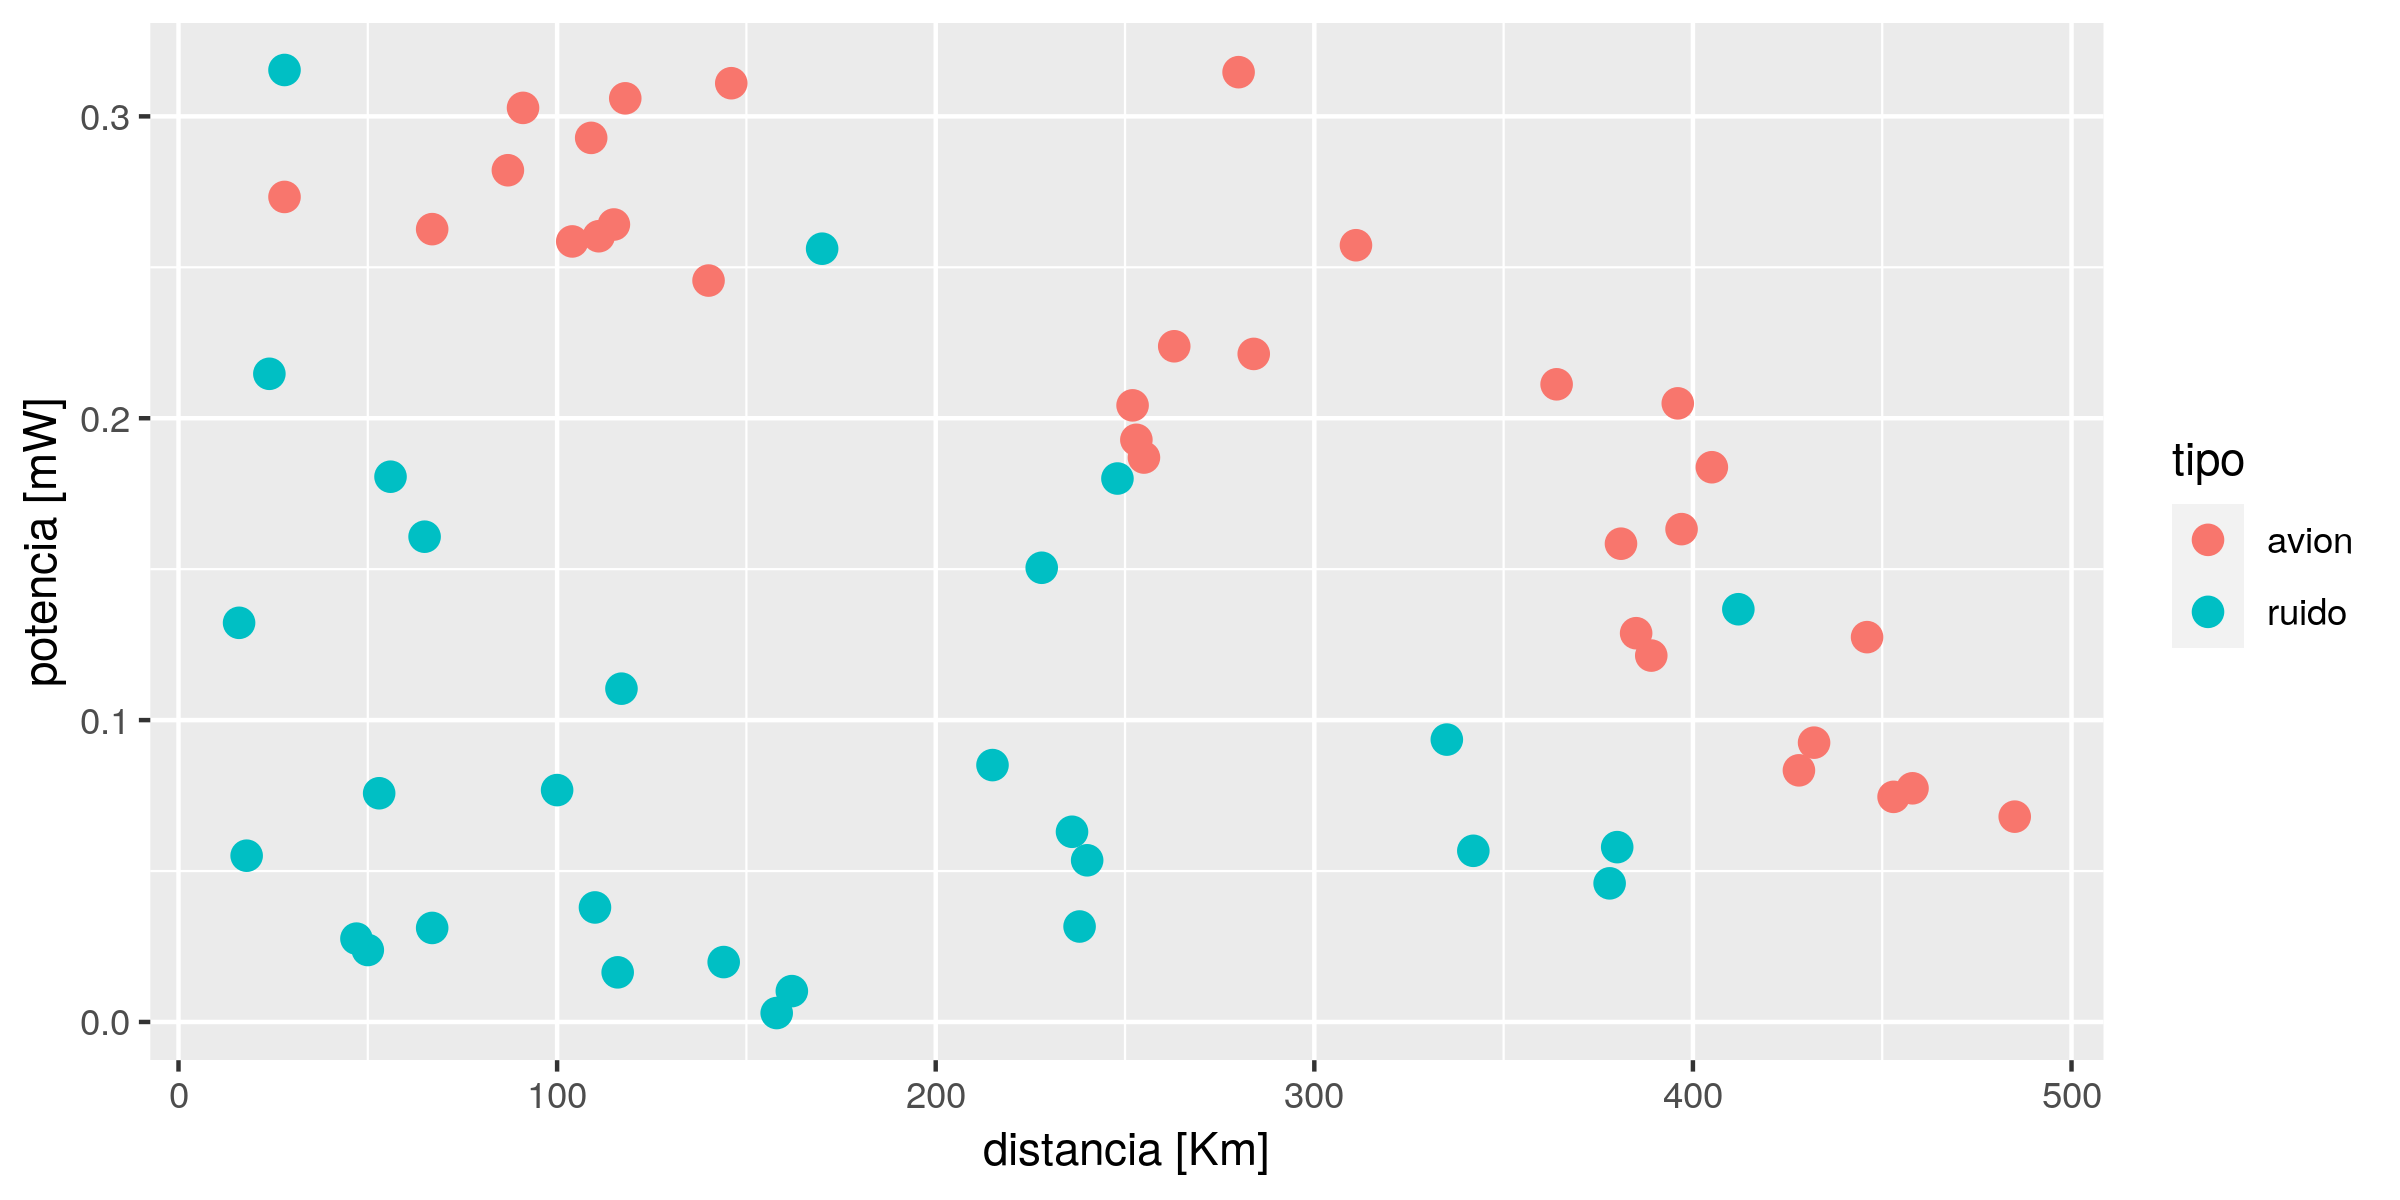

In [2]:
options(repr.plot.height=4,repr.plot.width=8,repr.plot.res = 300)

library(ggplot2)

radar<-read.csv("data/radar-lite.csv", stringsAsFactors = T)
summary(radar)
ggplot(radar,aes(x=distancia,y=potencia,color=tipo))+geom_point(size=3)+
 ylab("potencia [mW]")+xlab("distancia [Km]")

In [3]:
radar$tipo<-relevel(radar$tipo,ref="ruido")
summary(radar)

   distancia        potencia           tipo   
 Min.   : 16.0   Min.   :0.002959   ruido:29  
 1st Qu.:103.0   1st Qu.:0.066766   avion:31  
 Median :221.5   Median :0.143595             
 Mean   :219.8   Mean   :0.150970             
 3rd Qu.:367.5   3rd Qu.:0.229278             
 Max.   :485.0   Max.   :0.315358             

Podemos hacer una clasificación con un modelo lineal donde creamos una nueva columna *tipo.n* y le asignamos:
* avión  = 1
* ruido = 0

Utilizamos un modelo lineal tal que:
\\[
  tipo.n = \beta_0+\beta_1·distancia+\beta_2·potencia
\\]

Entonces:
* si tipo.n >= 0.5 es un avión
* si tipo.n <  0.5 es ruido

La recta que marcará el umbral será:
\\[
\begin{split}    
  0 &= \beta_0+\beta_1·distancia+\beta_2·potencia \\
  -\beta_2 potencia &= \beta_0+\beta_1·distancia - 0.5\\
  potencia &= \frac{0.5-\beta_0}{\beta_2}-\frac{\beta_1}{\beta_2}·distancia
\end{split}  
\\]


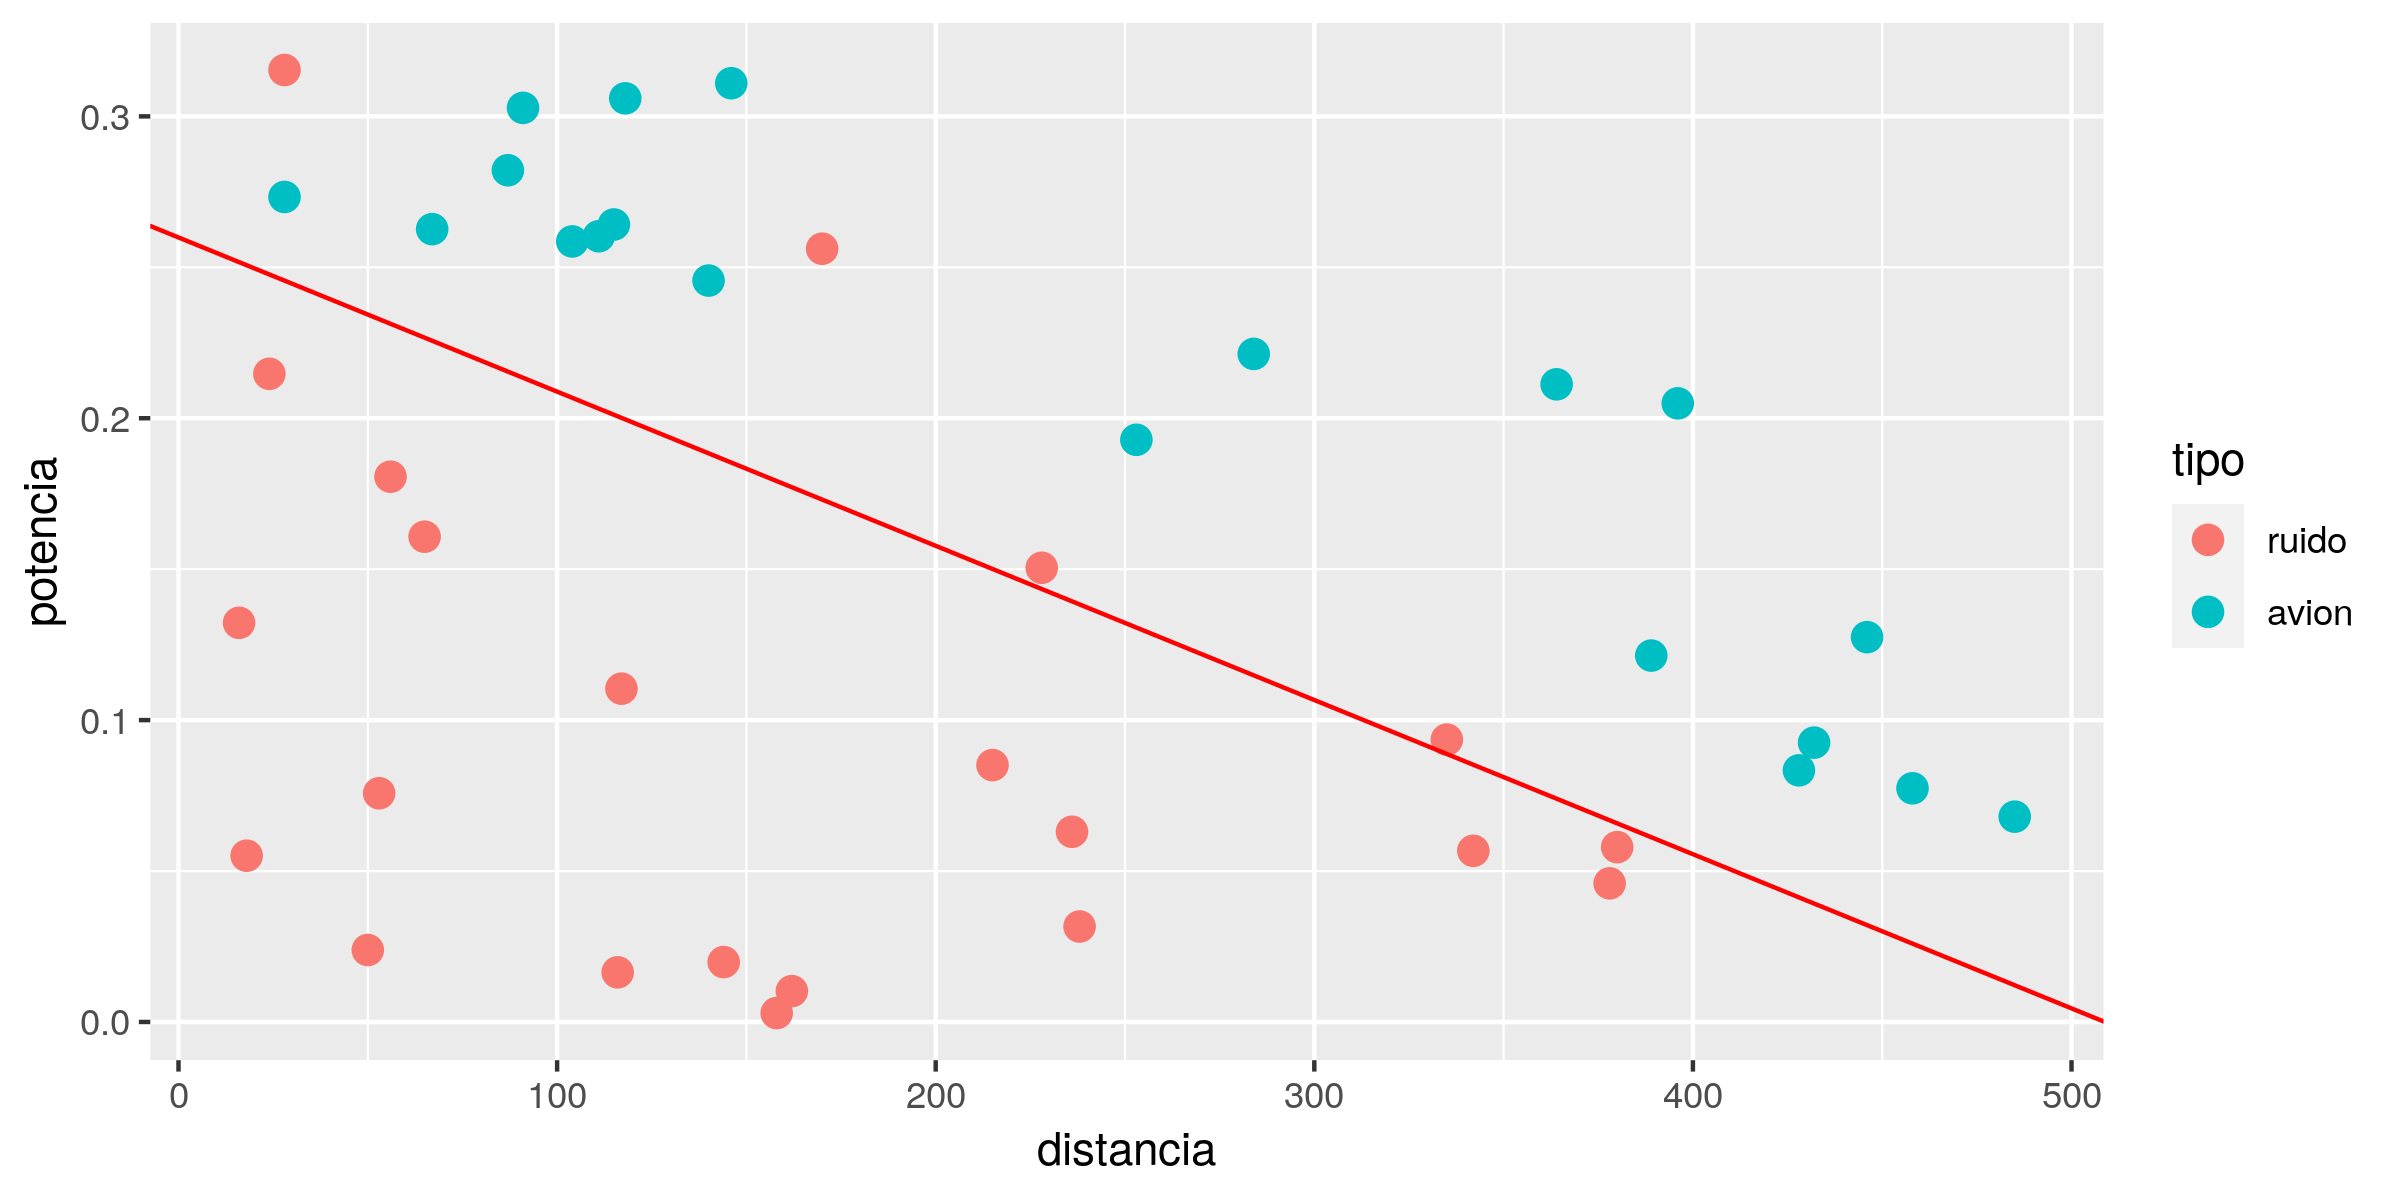

In [4]:
set.seed(1)
set.seed(2)

radar$tipo.n[radar$tipo=="avion"] <- 1
radar$tipo.n[radar$tipo=="ruido" ]<- 0


itrain<-sample(1:nrow(radar),round(nrow(radar)*0.7))
radar.train<- radar[itrain,]
radar.test <- radar[-itrain,]


modellm<-lm(data=radar.train,formula=tipo.n~distancia+potencia)
beta<-modellm$coefficients

ggplot(radar.train,aes(x=distancia,y=potencia,color=tipo))+geom_point(size=3)+
 geom_abline(intercept = (0.5-beta[1])/beta[3],slope = -beta[2]/beta[3], color="red" )

Pero esto no es del todo correcto porque los datos **NO** siguen una distribución gaussiana. Siguen una distribución **binomial** con dos posibles valores 0 o 1.

La distribución binomial es una generalización de la distribución de Bernoulli para $n$ sucesos independientes, cada uno de los cuales tiene dos posibles resultados Si/No con probabilidad $p$.

**Ejemplo:** Tiramos al aire 3 monedas y mirarmos cual es la probabilidad de que 2 salgan cara.

Variables que definen la distribución:
* p - probabilidad de éxito de un caso individual
* n - número de eventos totales que se desean medir
* k - número de eventos que ha salido SI.

Estimadores **media** ($\mu$) y **varianza** ($\sigma^2$):
\\[
\mu=n·p \qquad
\sigma^2=n·p·(1-p)
\\]

Si tenemos $n$ sucesos independientes que siguen una distribución de Bernoulli, ¿cual es la probabilidad de que $k$ sucesos sean positivos?. 
Si sabemos que la probabilidad de un suceso ($k=1$) que sigue una distribución Bernoulli viene dada por la función de distribución:
\\[
Pr_{Bernoulli}(X=k)=p^k(1-p)^{n-k} \qquad k \in \left\{0,1 \right\}.
\\]

Al tener $k$ sucesos donde $k \in \left\{0,1,2,...,n \right\}$, la función será la de Bernoulli multiplicada por el coeficiente binomial que acabamos de ver:
\\[
Pr(X=k)=\binom{n}{k}p^k(1-p)^{n-k}
\\]
La función acumulativa será:
\\[
Pr(X \leq k)= \sum_{i=0}^{k-1} \binom{n}{k}p^k(1-p)^{n-k}
\\]



#### función de enlace (link function)

Para pasar del dominio de números reales $(-\infty,\infty)$ al de probabilidades $[0,1]$ a vamos a utilizar la **función logística**:
\\[
p = h(x)=  \frac{1}{1+e^{-x}}
\\]
Su inversa se conoce como la función **logit**:
\\[
h^{-1}(p) = log \left( \frac{p}{1-p} \right)
\\]

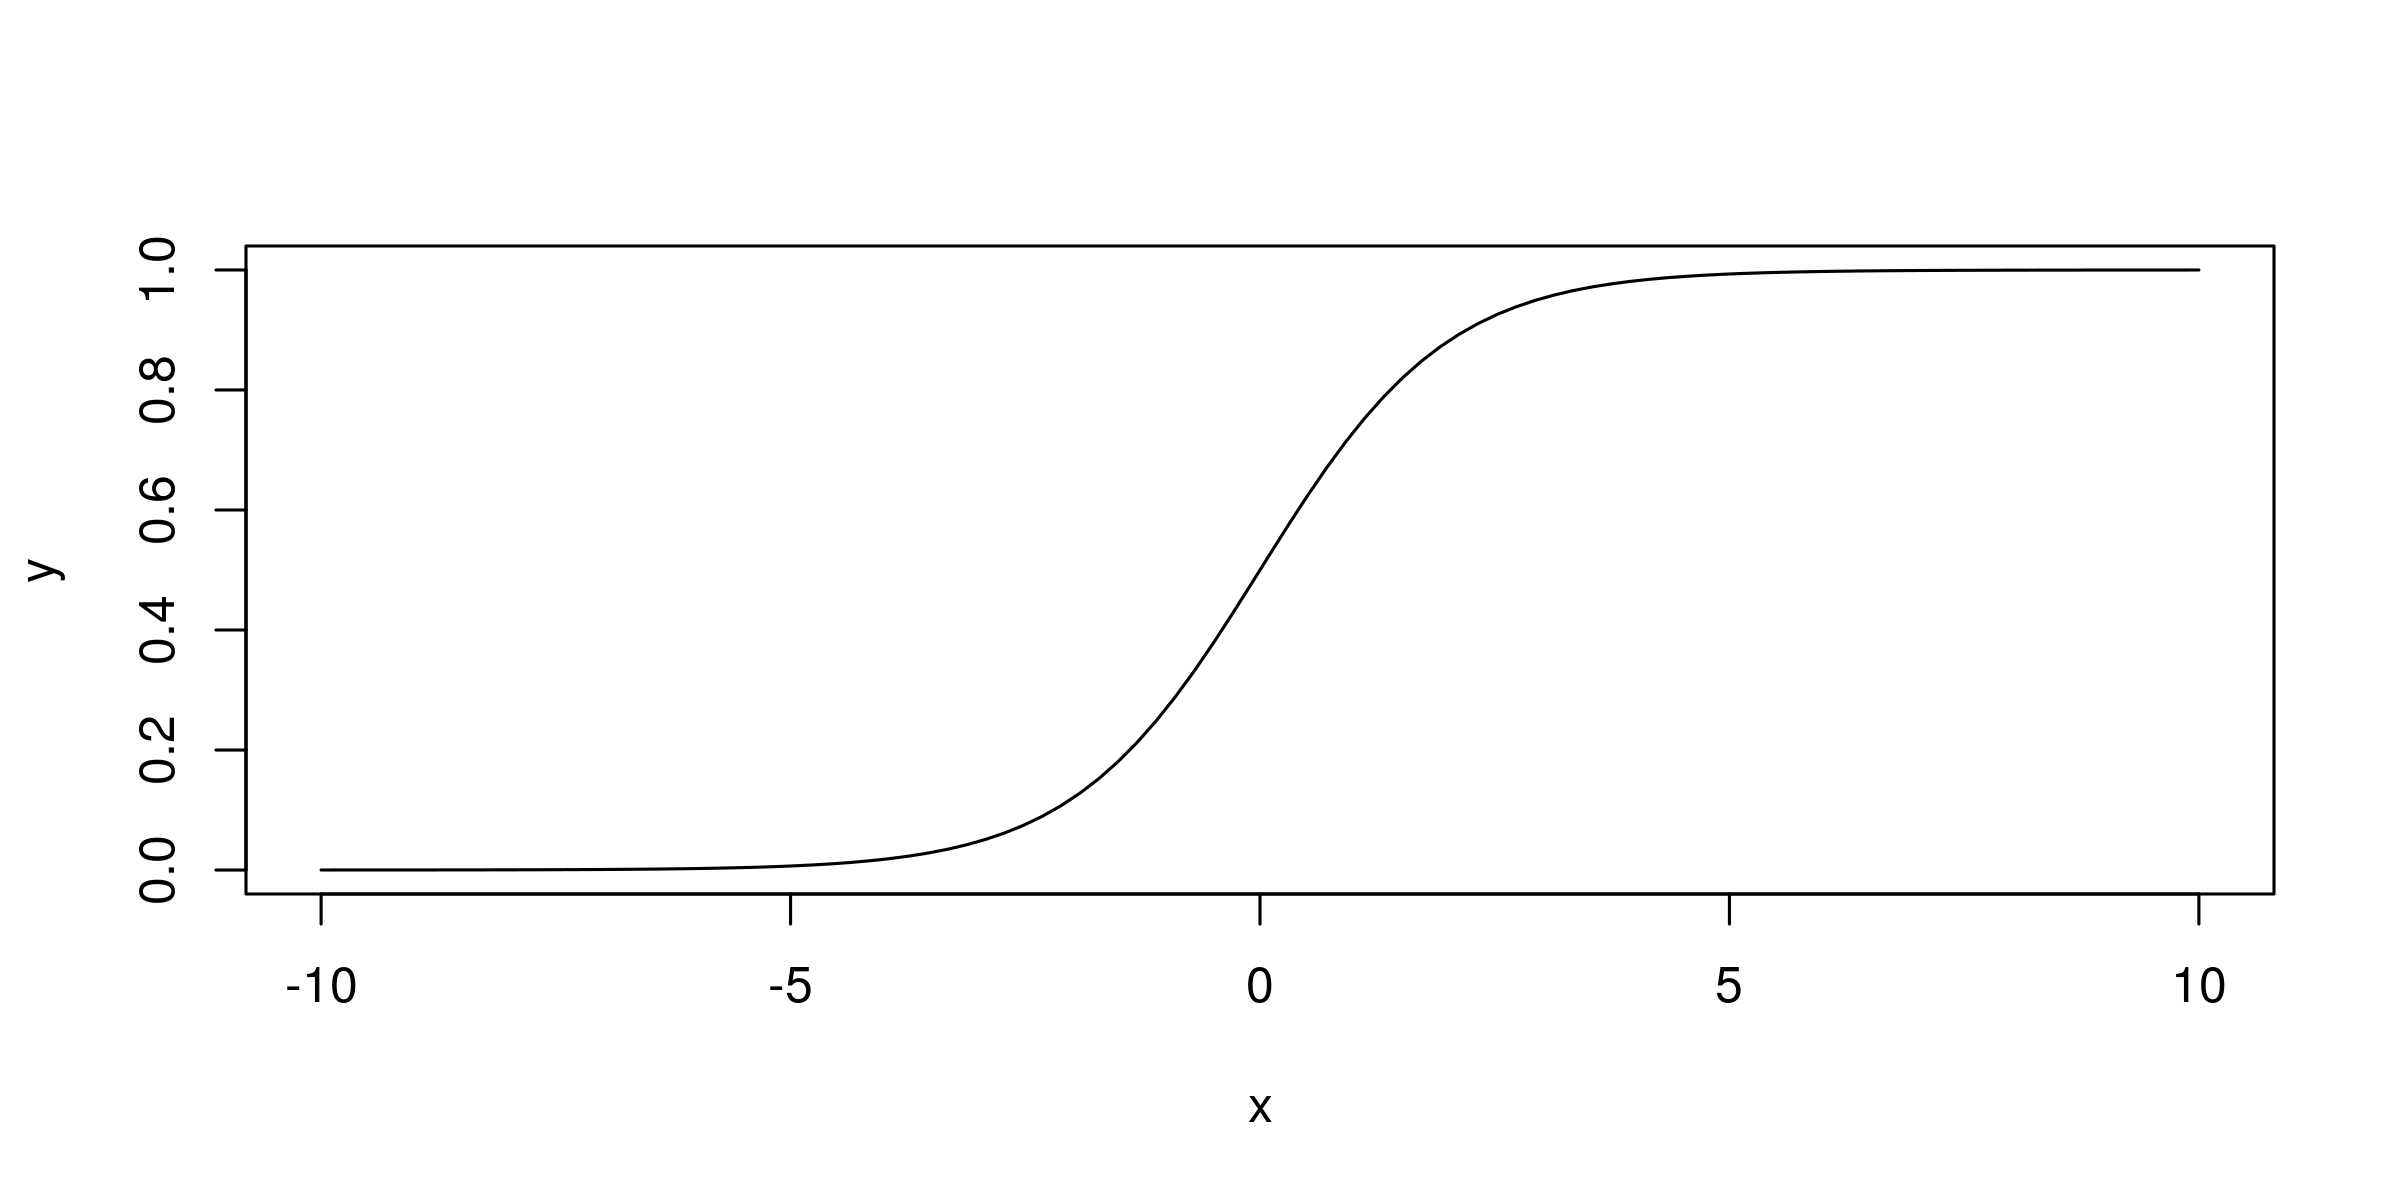

In [5]:
x<-seq(-10,10,length.out = 100)
y<-1/(1+exp(-x))
plot(x,y,t="l")

Es decir, cuando estemos trabajando con una **distribución binomial** un modelo lineal del tipo:
\\[
y = \beta \vec{x}+\beta_0
\\]
será:
\\[
y = p(x) = \frac{1}{1+e^{-\beta \vec{x}-\beta_0}} 
\\]
Ahora $p(x)$ es una función que muestra valores en el rango $[0,1]$, puede ser considerada como una probabilidad.

Y tenemos el siguiente clasificador:
* Seleccionamos clase 1 si p(x)>=0.5
* Seleccionamos clase 0 si p(x)< 0.5



Es decir, tenemos una probabilidad, su valor está en el rango $[0,1]$:
\\[
    p = \frac{1}{1-e^{-\hat{Y}}}= \frac{1}{1-e^{-(\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p)}}   
\\]

Definimos la razón de monomios (Odds ratio) como el cociente entre dos probabilidades, su valor está en el rango $[0,\infty]$:
\\[
Odds=\frac{p(x)}{1-p(x)} = \frac{\frac{1}{1+e^{-\beta \vec{x}-\beta_0}}}{1-\frac{1}{1+e^{-\beta \vec{x}-\beta_0}} }
\\]
\\[
Odds=\frac{p(x)}{1-p(x)} = \frac{1}{1+e^{-\beta \vec{x}-\beta_0}-1} 
\\]
\\[
Odds=\frac{p(x)}{1-p(x)} = e^{\beta \vec{x}+\beta_0}
\\]


\\[
 Odds = \frac{p}{1-p}=\frac{\frac{1}{1-e^{-(\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p)}}}{\frac{e^{-(\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p)}}{1-e^{-(\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p)}}}=e^{(\beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p)}
\\]

Si aplicamos el logaritmo a la razón de monomios tenemos un valor que está en el rango $[-\infty,\infty]$:
\\[
 log(Odds)= log \left(\frac{p}{1-p} \right) = \beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p
\\]

La función de coste que vamos a tratar de minimizar será:
\\[
\begin{split}
Cost(p(x),y) &= {1 \over n} \sum_{i=0}^n{(y-\hat{y})^2}\\
Cost(p(x),y) &= {1 \over n} \sum_{i=0}^n{(y-p(x))^2}
\end{split}
\\]
Que transformaremos en:
\\[
Cost(p(x),y) = -y ·log(p(x))-(1-y)·log(1-p(x))
\\]


In [6]:
summary(radar.train)
summary(radar.test)

   distancia        potencia           tipo        tipo.n      
 Min.   : 16.0   Min.   :0.002959   ruido:22   Min.   :0.0000  
 1st Qu.: 88.0   1st Qu.:0.064261   avion:20   1st Qu.:0.0000  
 Median :152.0   Median :0.129854              Median :0.0000  
 Mean   :201.7   Mean   :0.150611              Mean   :0.4762  
 3rd Qu.:340.2   3rd Qu.:0.253519              3rd Qu.:1.0000  
 Max.   :485.0   Max.   :0.315358              Max.   :1.0000  

   distancia        potencia          tipo        tipo.n      
 Min.   : 47.0   Min.   :0.02761   ruido: 7   Min.   :0.0000  
 1st Qu.:142.5   1st Qu.:0.07513   avion:11   1st Qu.:0.0000  
 Median :259.0   Median :0.16085              Median :1.0000  
 Mean   :261.9   Mean   :0.15181              Mean   :0.6111  
 3rd Qu.:384.0   3rd Qu.:0.19994              3rd Qu.:1.0000  
 Max.   :453.0   Max.   :0.31463              Max.   :1.0000  

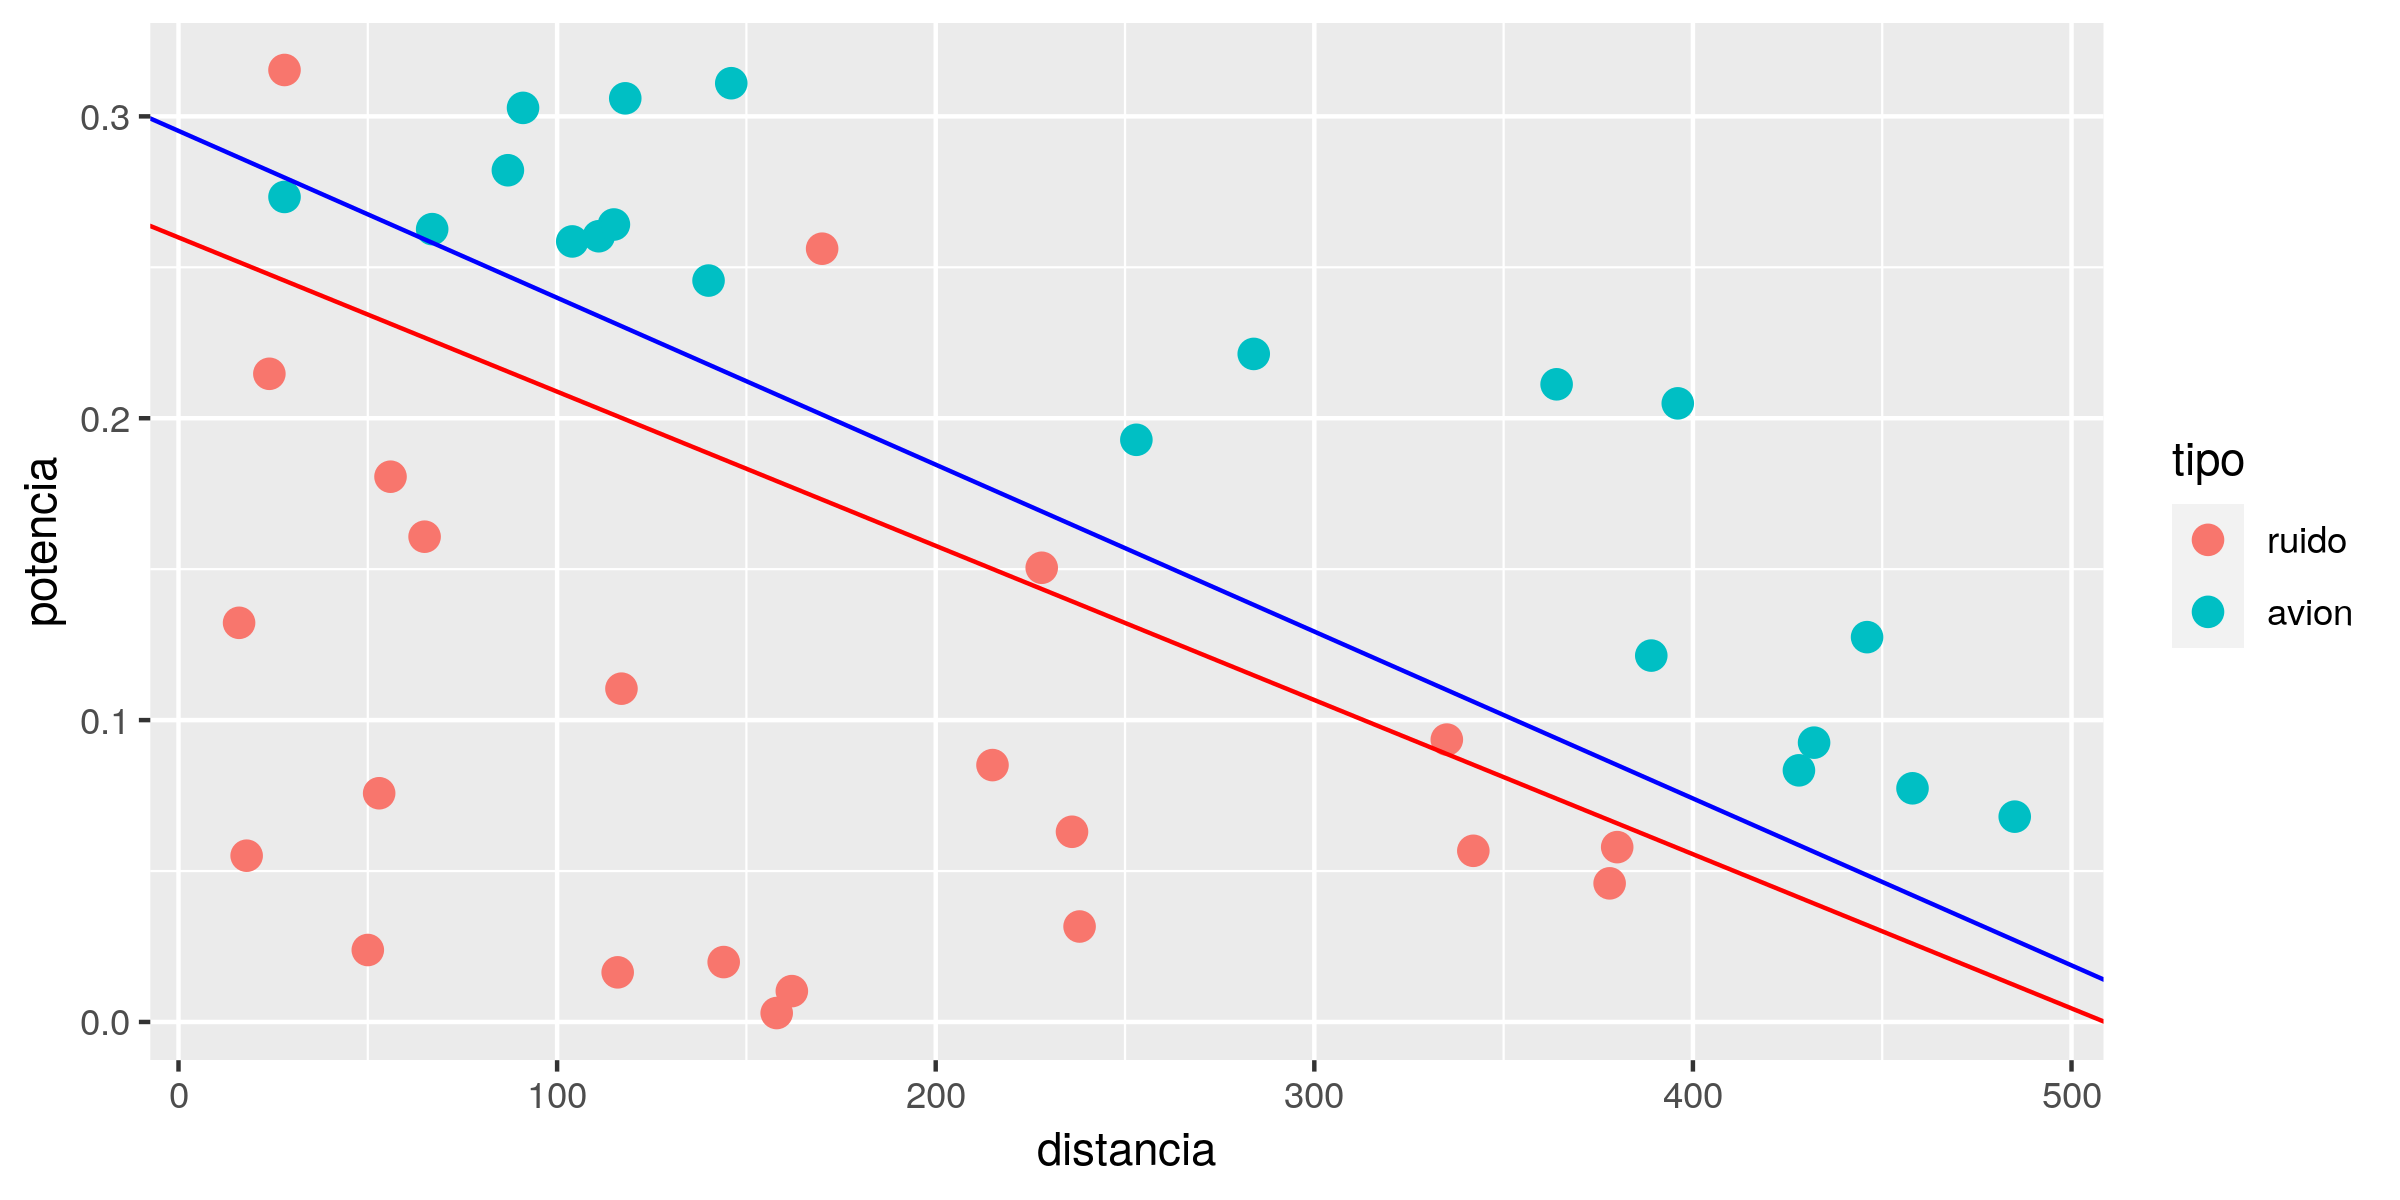

In [7]:
model<-glm(data=radar.train,formula=tipo~distancia+potencia,family=binomial(link='logit'))

betalg<-model$coefficients

ggplot(radar.train,aes(x=distancia,y=potencia,color=tipo))+geom_point(size=3)+
 geom_abline(intercept = (0.5-beta[1])/beta[3],slope = -beta[2]/beta[3], color="red" )    +
 geom_abline(intercept = -betalg[1]/betalg[3],slope = -betalg[2]/betalg[3], color="blue" )

La salida del modelo es log(odds):
\\[
 y = log(Odds) = \beta_1 X_1+\beta_2 X_2+\cdots +\beta_p X_p
\\]
Si queremos la probabilidad tenemos que aplicar un poco de cálculo:
\\[
 Odds = \frac{p}{1-p}
\\]
\\[
 y = log(Odds) = log \left( \frac{p}{1-p} \right) \\
 e^y = \left( \frac{p}{1-p} \right) \\
 e^y·(1-p) = p \\
 e^y = p+p·e^y \\
 e^y = p·(1+e^y) \\
 p=\frac{e^y}{1+e^y}
\\]




`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



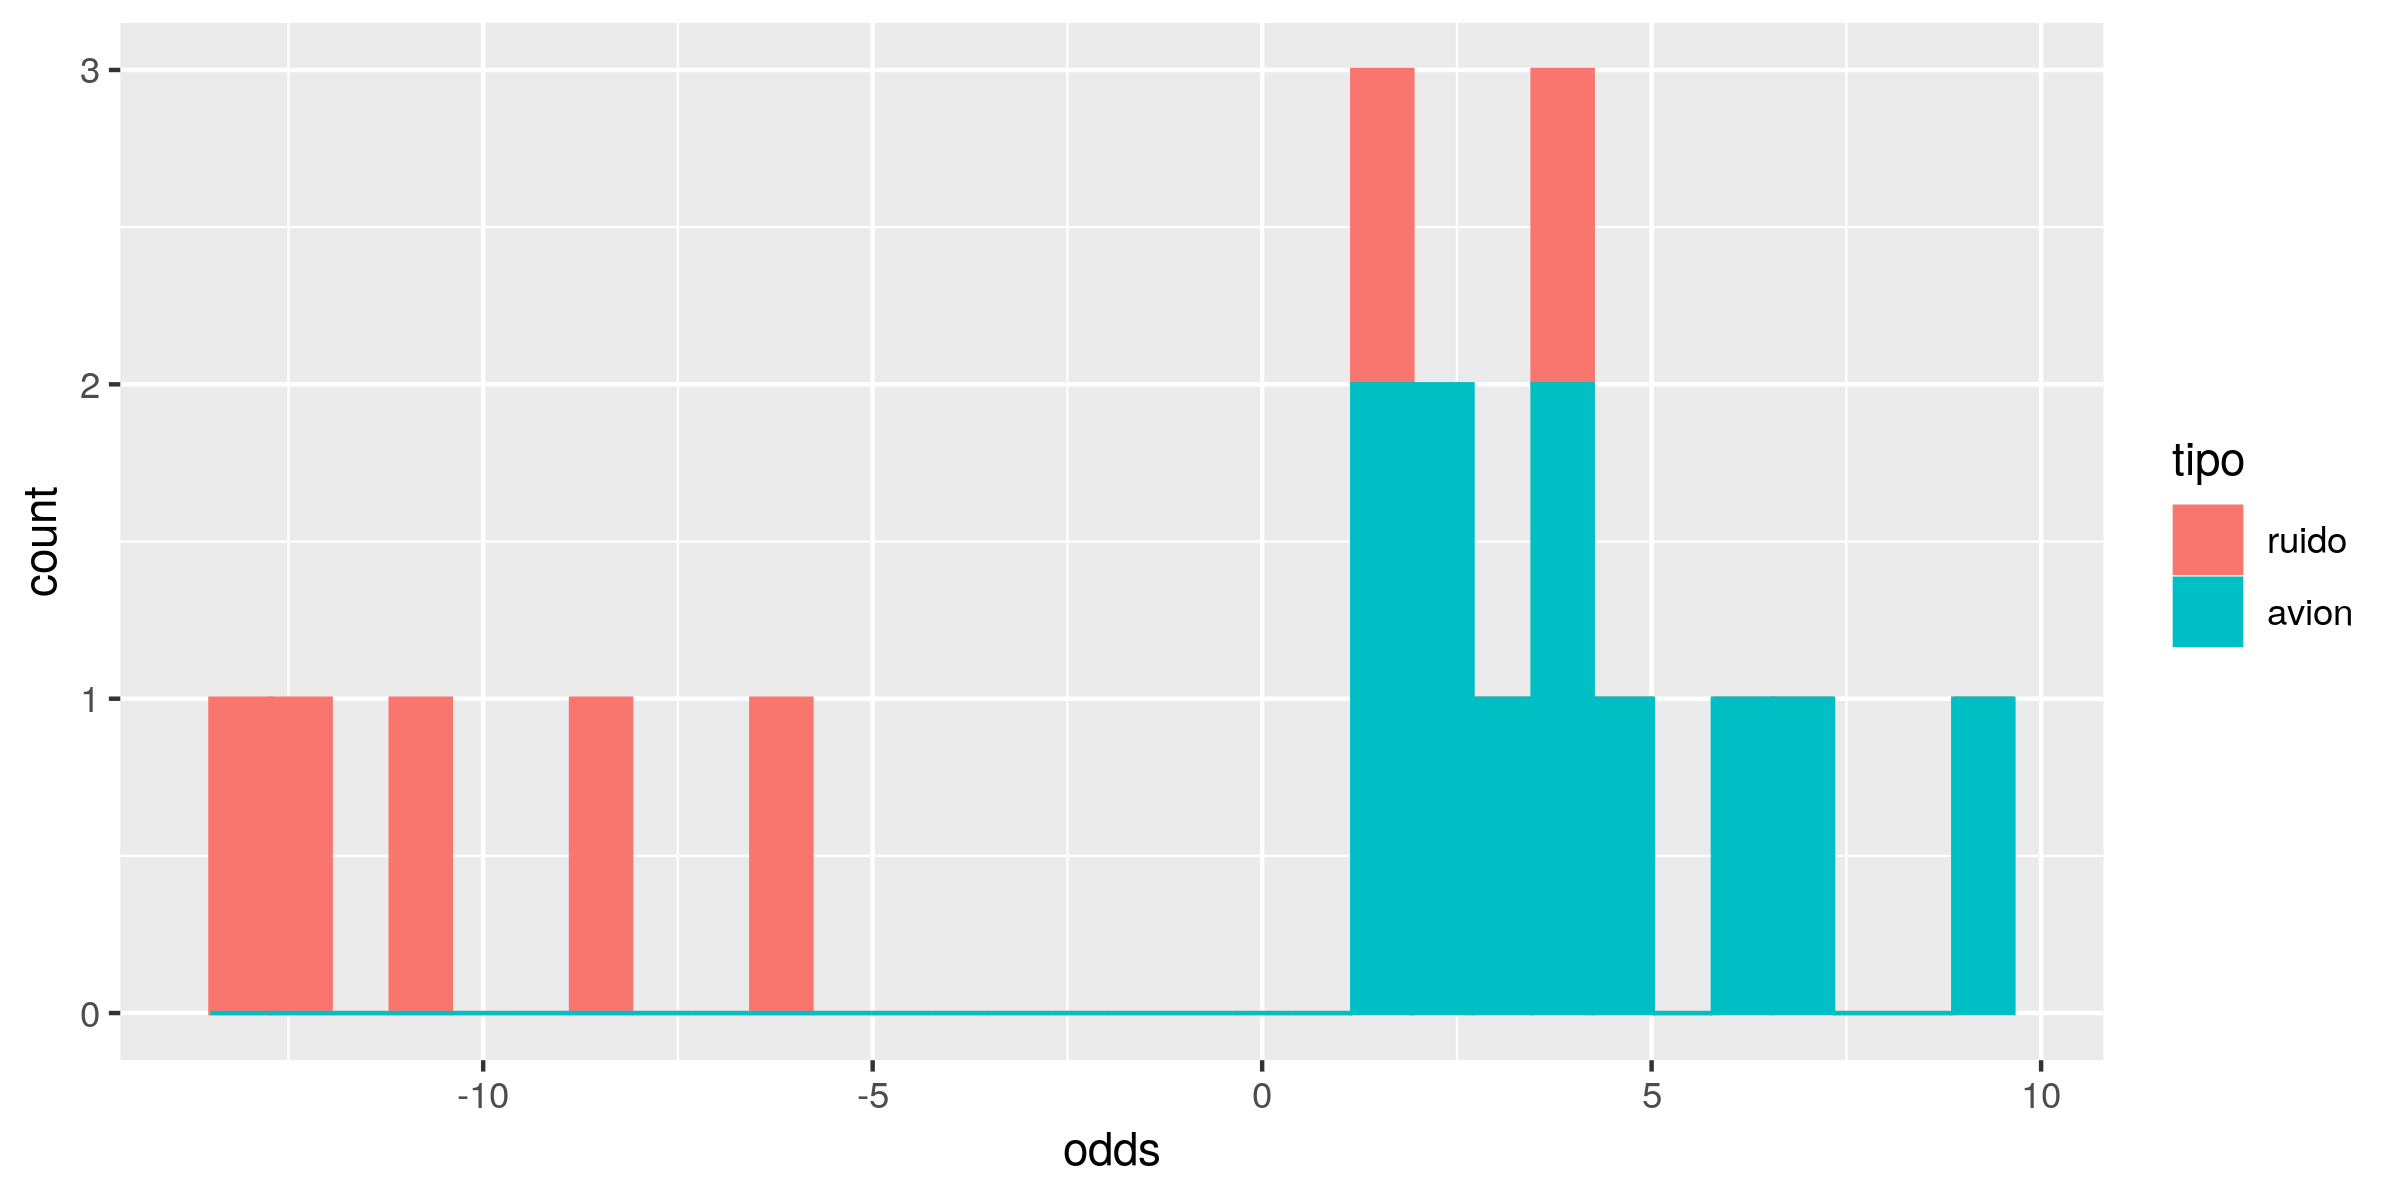

In [8]:
out<-radar.test
out["y"]<-predict(model,radar.test)

ggplot(out,aes(x=y,color=tipo))+geom_histogram(aes(fill=tipo))+xlab("odds")

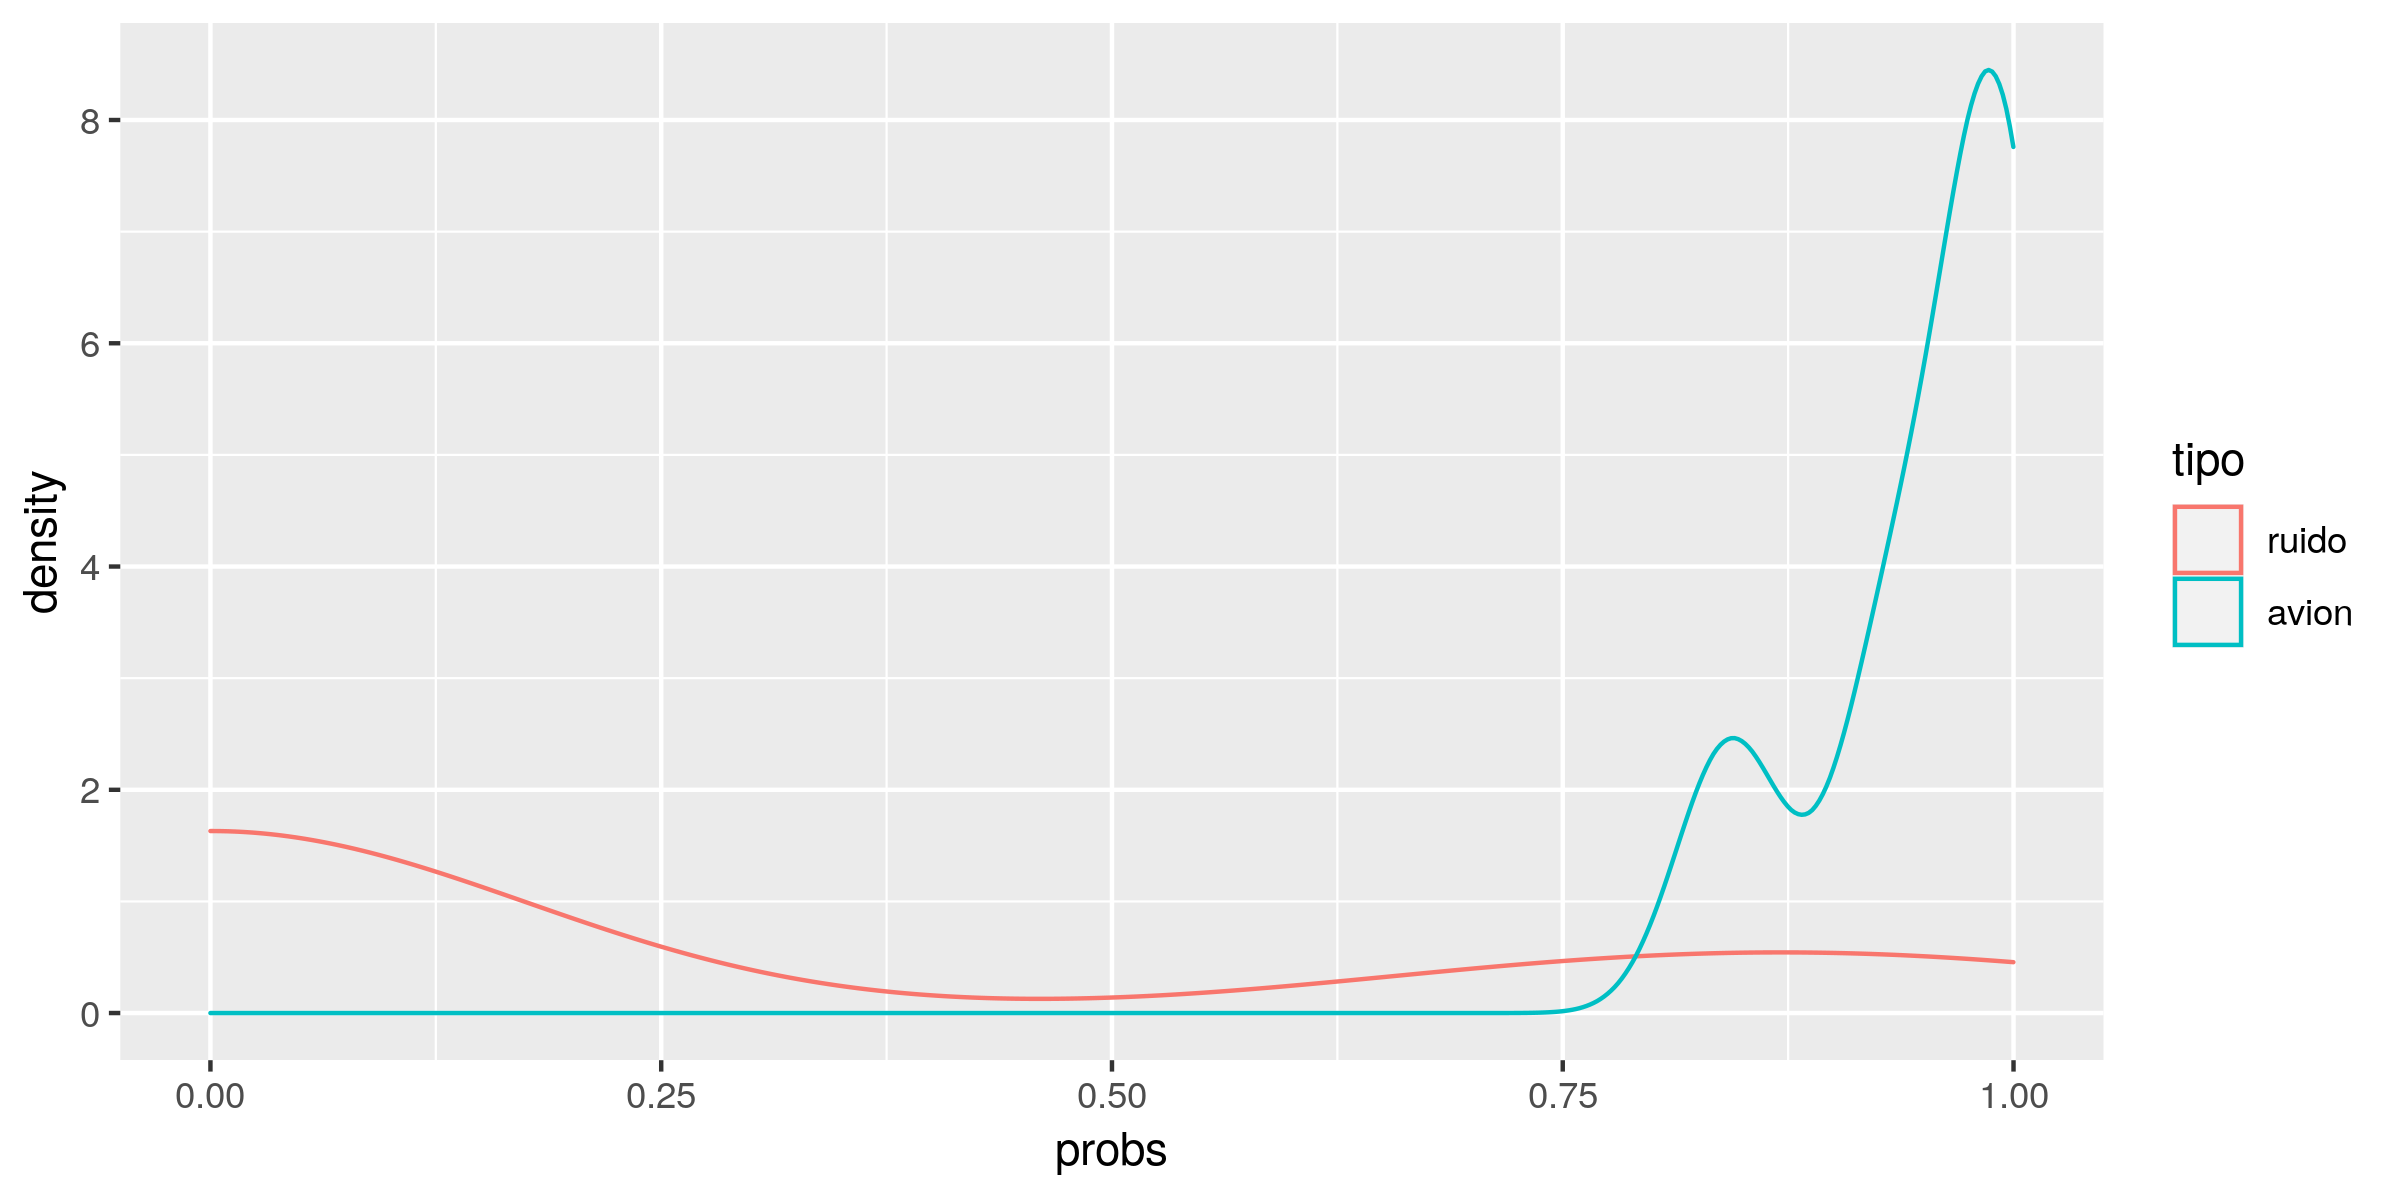

In [9]:
out<-radar.test
out["y"]<-predict(model,radar.test)
out["probs"]<-exp(out["y"])/(1+exp(out["y"]))
out["probs"]<-1/(1+exp(-out["y"]))

ggplot(out,aes(x=probs,color=tipo))+geom_density()

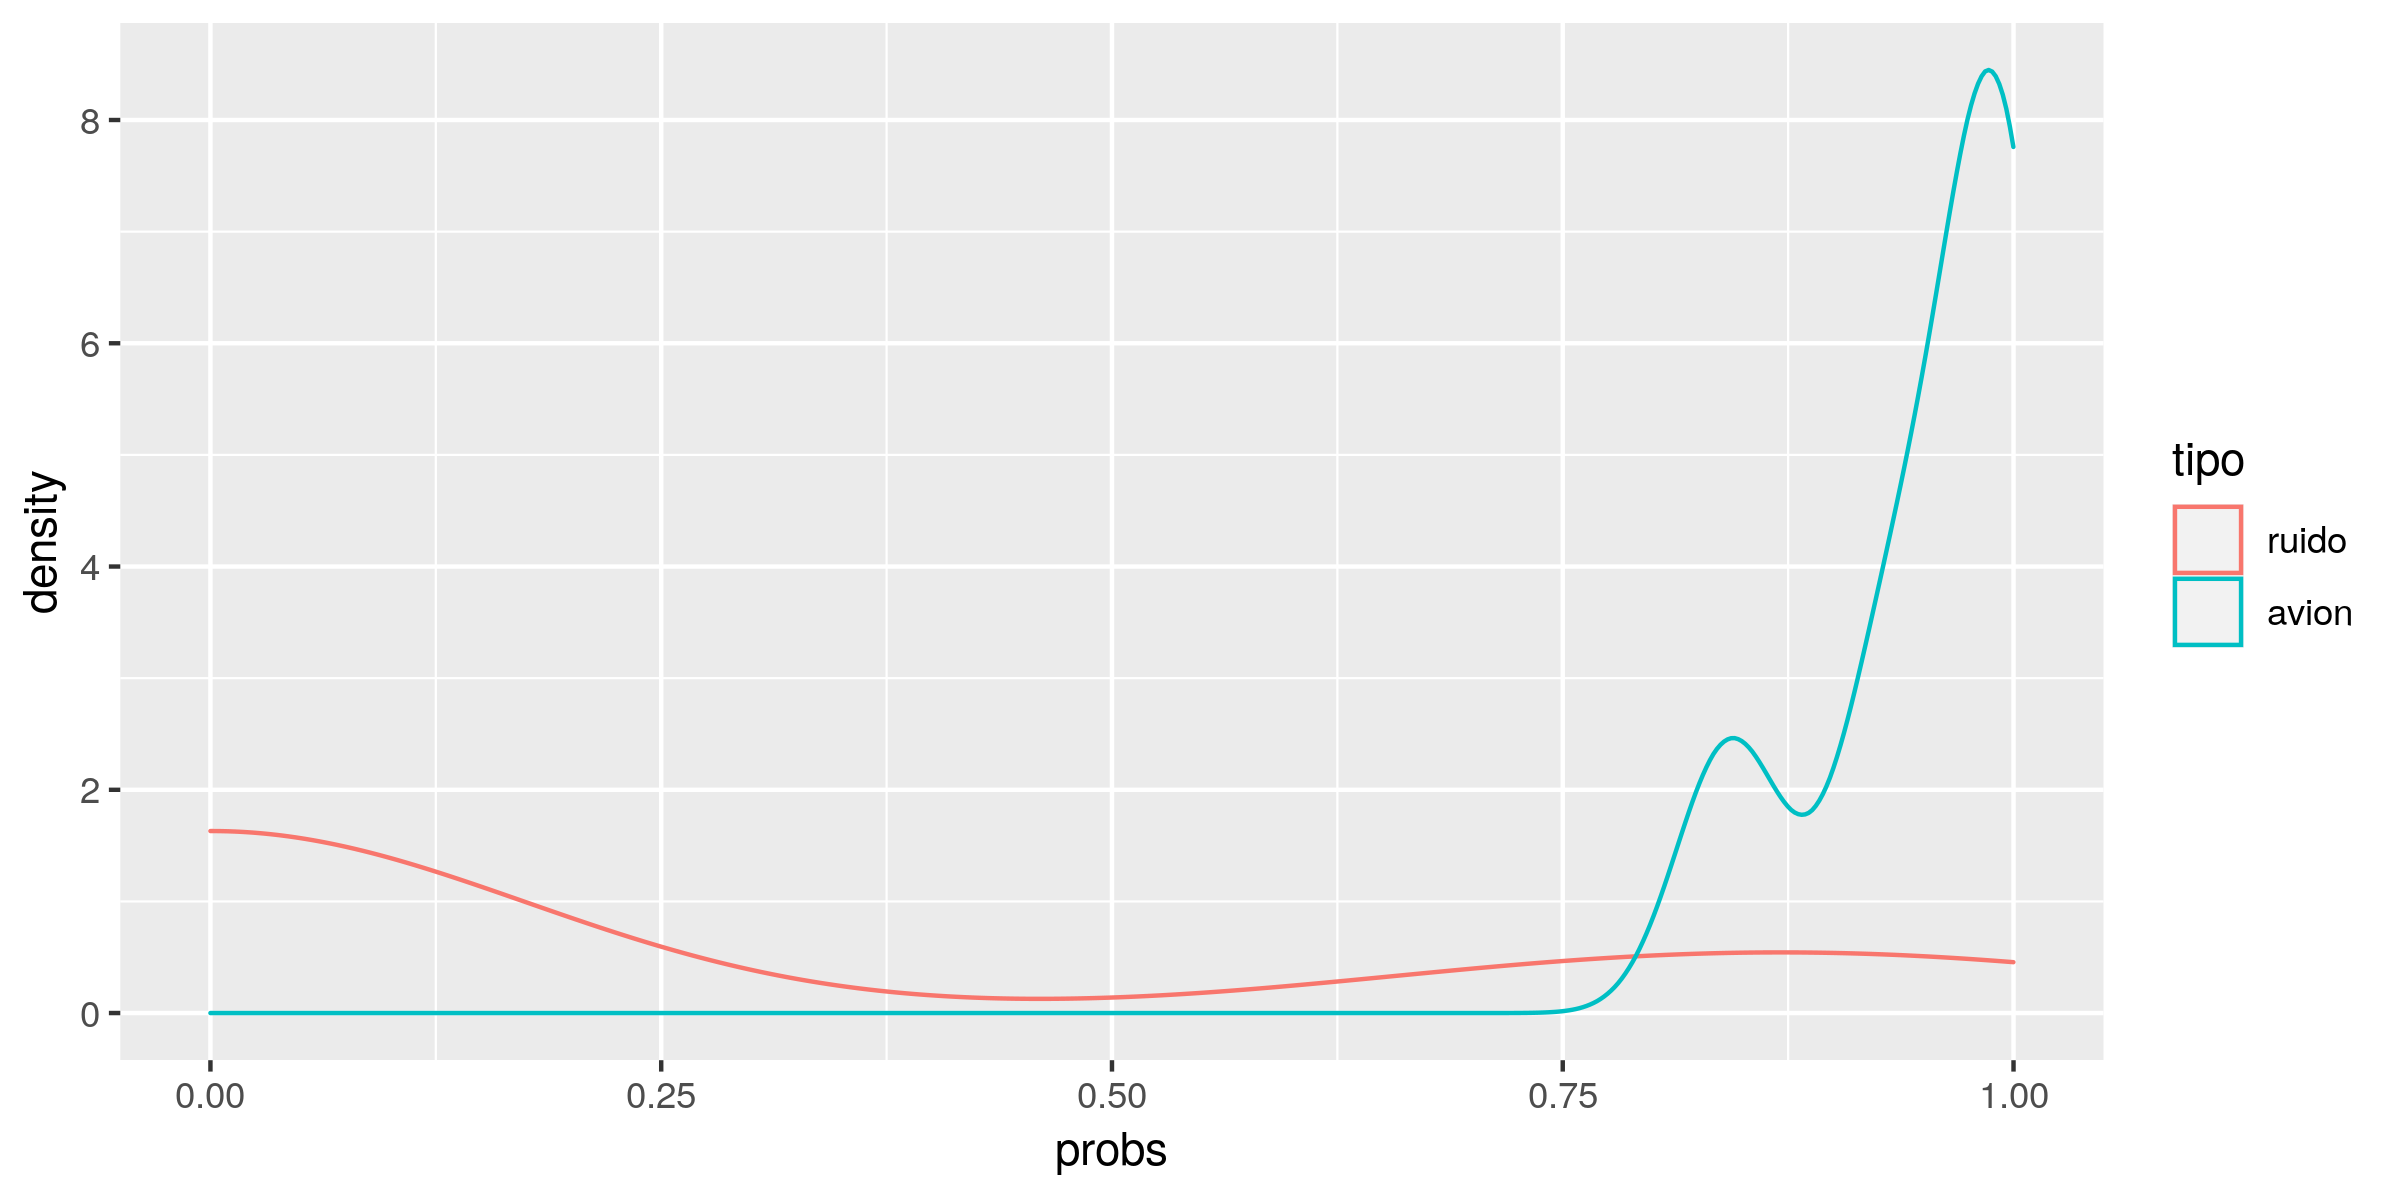

In [10]:
out["probs"]<-predict(model,radar.test,type="response")

ggplot(out,aes(x=probs,color=tipo))+geom_density()

## Matriz de confusión

Aqui lo que tenemos es un clasificador con dos hipótesis $H_0$ (hipótesis negativa) y $H_1$ (hipótesis positiva). 
Si nuestro test estadístico dice que la hipótesis $H_1$ es cierta pero en realidad la que es cierta es la hipótesis $H_0$ estaremos cometiendo un error.
El tipo de error depende de si nos hemos equivocado prediciendo $H_0$ o $H_1$.

|.|Elegimos $H_0$|Elegimos $H_1$|
|-|-|-|
|$H_0$ cierta| No hay error |Error tipo I, falso positivo|
|$H_1$ cierta| Error tipo II, falso negativo| No hay error |


La matriz de confusión lo que hace es contar el número de ocurrencias que ha habido en cada celda:

       elegimos
real    ruido avion
  ruido     6     1
  avion     2     9

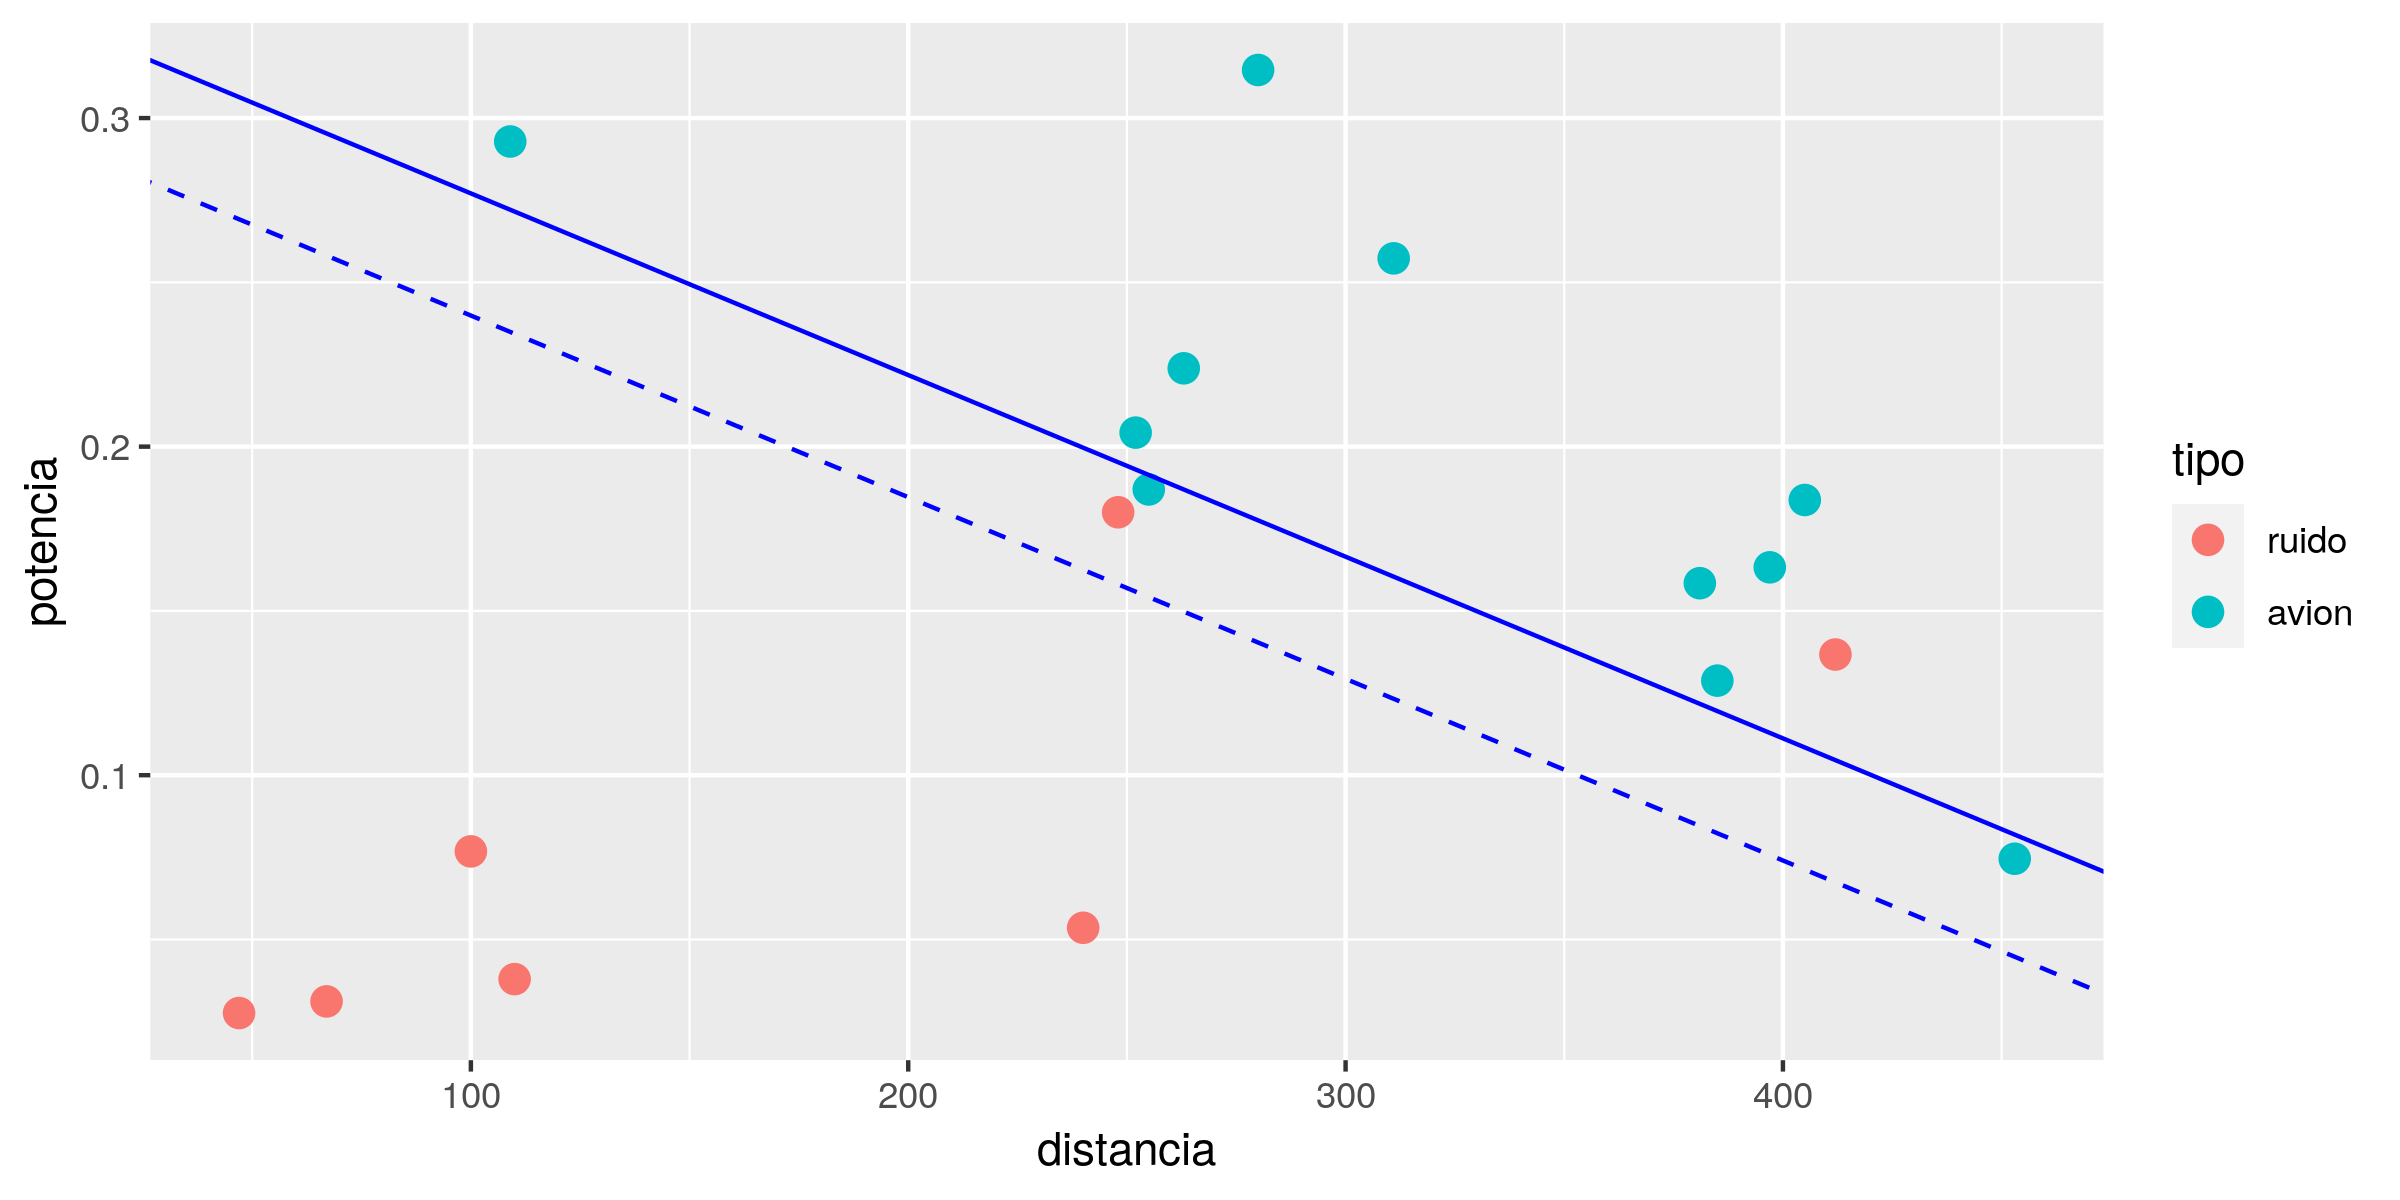

In [11]:
M<-matrix(rep(0,4),ncol = 2)
umbral <- 2
radar_pred  <- predict(model,radar.test)
y_est=factor(ifelse(radar_pred < umbral,0,1),labels=c("ruido","avion"))


M = table(real=radar.test$tipo,elegimos=y_est)
M

ggplot(radar.test,aes(x=distancia,y=potencia,color=tipo))+geom_point(size=3)+
 geom_abline(intercept = (-betalg[1])/betalg[3],slope = -betalg[2]/betalg[3], color="blue", linetype="dashed")+
 geom_abline(intercept = (umbral-betalg[1])/betalg[3],slope = -betalg[2]/betalg[3], color="blue" )

### Medidas de calidad

Imaginemos que tenemos la siguiente matriz de confusión:

|.|Predecimos condición negativa|Predecimos condición positiva|
|-|-|-|
|Condición negativa| $M_{11}$ | $M_{12}$|
|Condición positiva| $M_{21}$ | $M_{22}$ |

**Precisión** : $\frac{M_{22}}{M_{12}+M_{22}}$. Cuantos aciertos tengo del total de predicciones. Nos habla de **calidad**.

**Exhaustividad** (recall, true positive rate): $\frac{M_{22}}{M_{21}+M_{22}}$. Que ratio de los aciertos positivos soy capaz de encontrar. Nos habla de **cantidad** de encuentros.

**Exactitud** (Accuracy): $\frac{M_{11}+M_{22}}{M_{11}+M_{12}+M_{21}+M_{22}}$: Cuantas predicciones correctas he hecho.

**Valor-F**: $F_\beta=(1+\beta^2)\frac{Precisión·Exhaustividad}{\beta^2·Precisión+Exhaustividad}$

**Probabilidad de falso positivo** (false positive rate): $\frac{M_{12}}{M_{12}+M_{11}}$. Cuantos positivos **erróneos** he detectado de todos los negativos que hay.

A veces la matriz de confusión se muestra cambiada, de hecho Python lo hace así, intercambia las filas y las columnas. Más información aquí:
https://towardsdatascience.com/the-two-variations-of-confusion-matrix-get-confused-never-again-8d4fb00df308

In [12]:
fscore<-function(M,beta){
    pr=M[1,1]/(M[1,2]+M[1,1])
    rc=M[1,1]/(M[2,1]+M[1,1])
    (1+beta^2)*pr*rc/(beta^2*pr+rc)
}

paste("Precision:",M[2,2]/(M[1,2]+M[2,2]))
paste("Recall, true positive rate:",   M[2,2]/(M[2,1]+M[2,2]))
paste("False positive rate:",   M[1,2]/(M[1,2]+M[1,1]))
paste("Accuracy:", (M[1,1]+M[2,2])/(M[1,1]+M[1,2]+M[2,1]+M[2,2]))
paste("F0.5-score",fscore(M,0.5))
paste("F1-score",fscore(M,1))
paste("F2-score",fscore(M,beta=2))

[1] "Precision: 0.9"

[1] "Recall, true positive rate: 0.818181818181818"

[1] "False positive rate: 0.142857142857143"

[1] "Accuracy: 0.833333333333333"

[1] "F0.5-score 0.833333333333333"

[1] "F1-score 0.8"

[1] "F2-score 0.769230769230769"

## Curva ROC

La curva ROC fue comenzada a usar durante la segunda guerra mundial para el análisis de las señales de radar. Después del ataque de Pearl Harbor en 1941, la armada de EEUU comenzó un programa de investigación para aumentar la predicción de los radares a la hora de detectar aviones japoneses. Para ello midieron la habiliad de un radar de detectar esas señales, esa medida la llamaron "Receiver Operating Characteristic".

Se utiliza para ver la calidad de un detector, un clasificador binario capaz de detectar un elemento.
Se hace un barrido por todos los umbrales y se mide el valor de positivo verdadero en función de falso positivo.

In [26]:
umbral<- -10
radar_pred  <-predict(model,radar.test)

df_preds<-data.frame(pred=radar_pred,
                     tipo_pred=factor(ifelse(radar_pred < umbral,0,1),labels=c("ruido","avion")),
                     tipo_real=radar.test$tipo)
df_preds<-df_preds[order(df_preds$pred, decreasing=FALSE),]

M<-table(df_preds$tipo_real,df_preds$tipo_pred)
 #table(real=radar.test$tipo,elegimos=y_est)

#Recall, Exhaustividad, Tasa Verdadero positivo
truePositive<-M[2,2]/(M[2,2]+M[2,1]) 

#Tasa Falso positivo
falsePositive<-M[1,2]/(M[1,2]+M[1,1])
paste("tp:",truePositive,"  fp:",falsePositive)
M

df_preds

[1] "tp: 1   fp: 0.571428571428571"

       
        ruido avion
  ruido     3     4
  avion     0    11

,pred,tipo_pred,tipo_real
,<dbl>,<fct>,<fct>
14,-12.998054,ruido,ruido
49,-12.212471,ruido,ruido
5,-10.568299,ruido,ruido
52,-8.774266,avion,ruido
4,-5.860805,avion,ruido
42,1.181285,avion,ruido
30,1.605634,avion,avion
10,1.763440,avion,avion
22,2.499537,avion,avion


In [24]:
calctp_fp<-function(y_predict,y_real,th){
    y_est<-ifelse(y_predict<th,0,1)

    M<-table(y_real,y_est)
    #print(M)
    if (ncol(M)==2 && nrow(M)==2){
        truePositive<-M[2,2]/(M[2,2]+M[2,1])                     
        falsePositive<-M[1,2]/(M[1,2]+M[1,1])
        c(tp=truePositive,fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}

In [25]:
calctp_fp(df_preds$pred,df_preds$tipo_real,th=-1)

tp        fp 
1.0000000 0.2857143

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


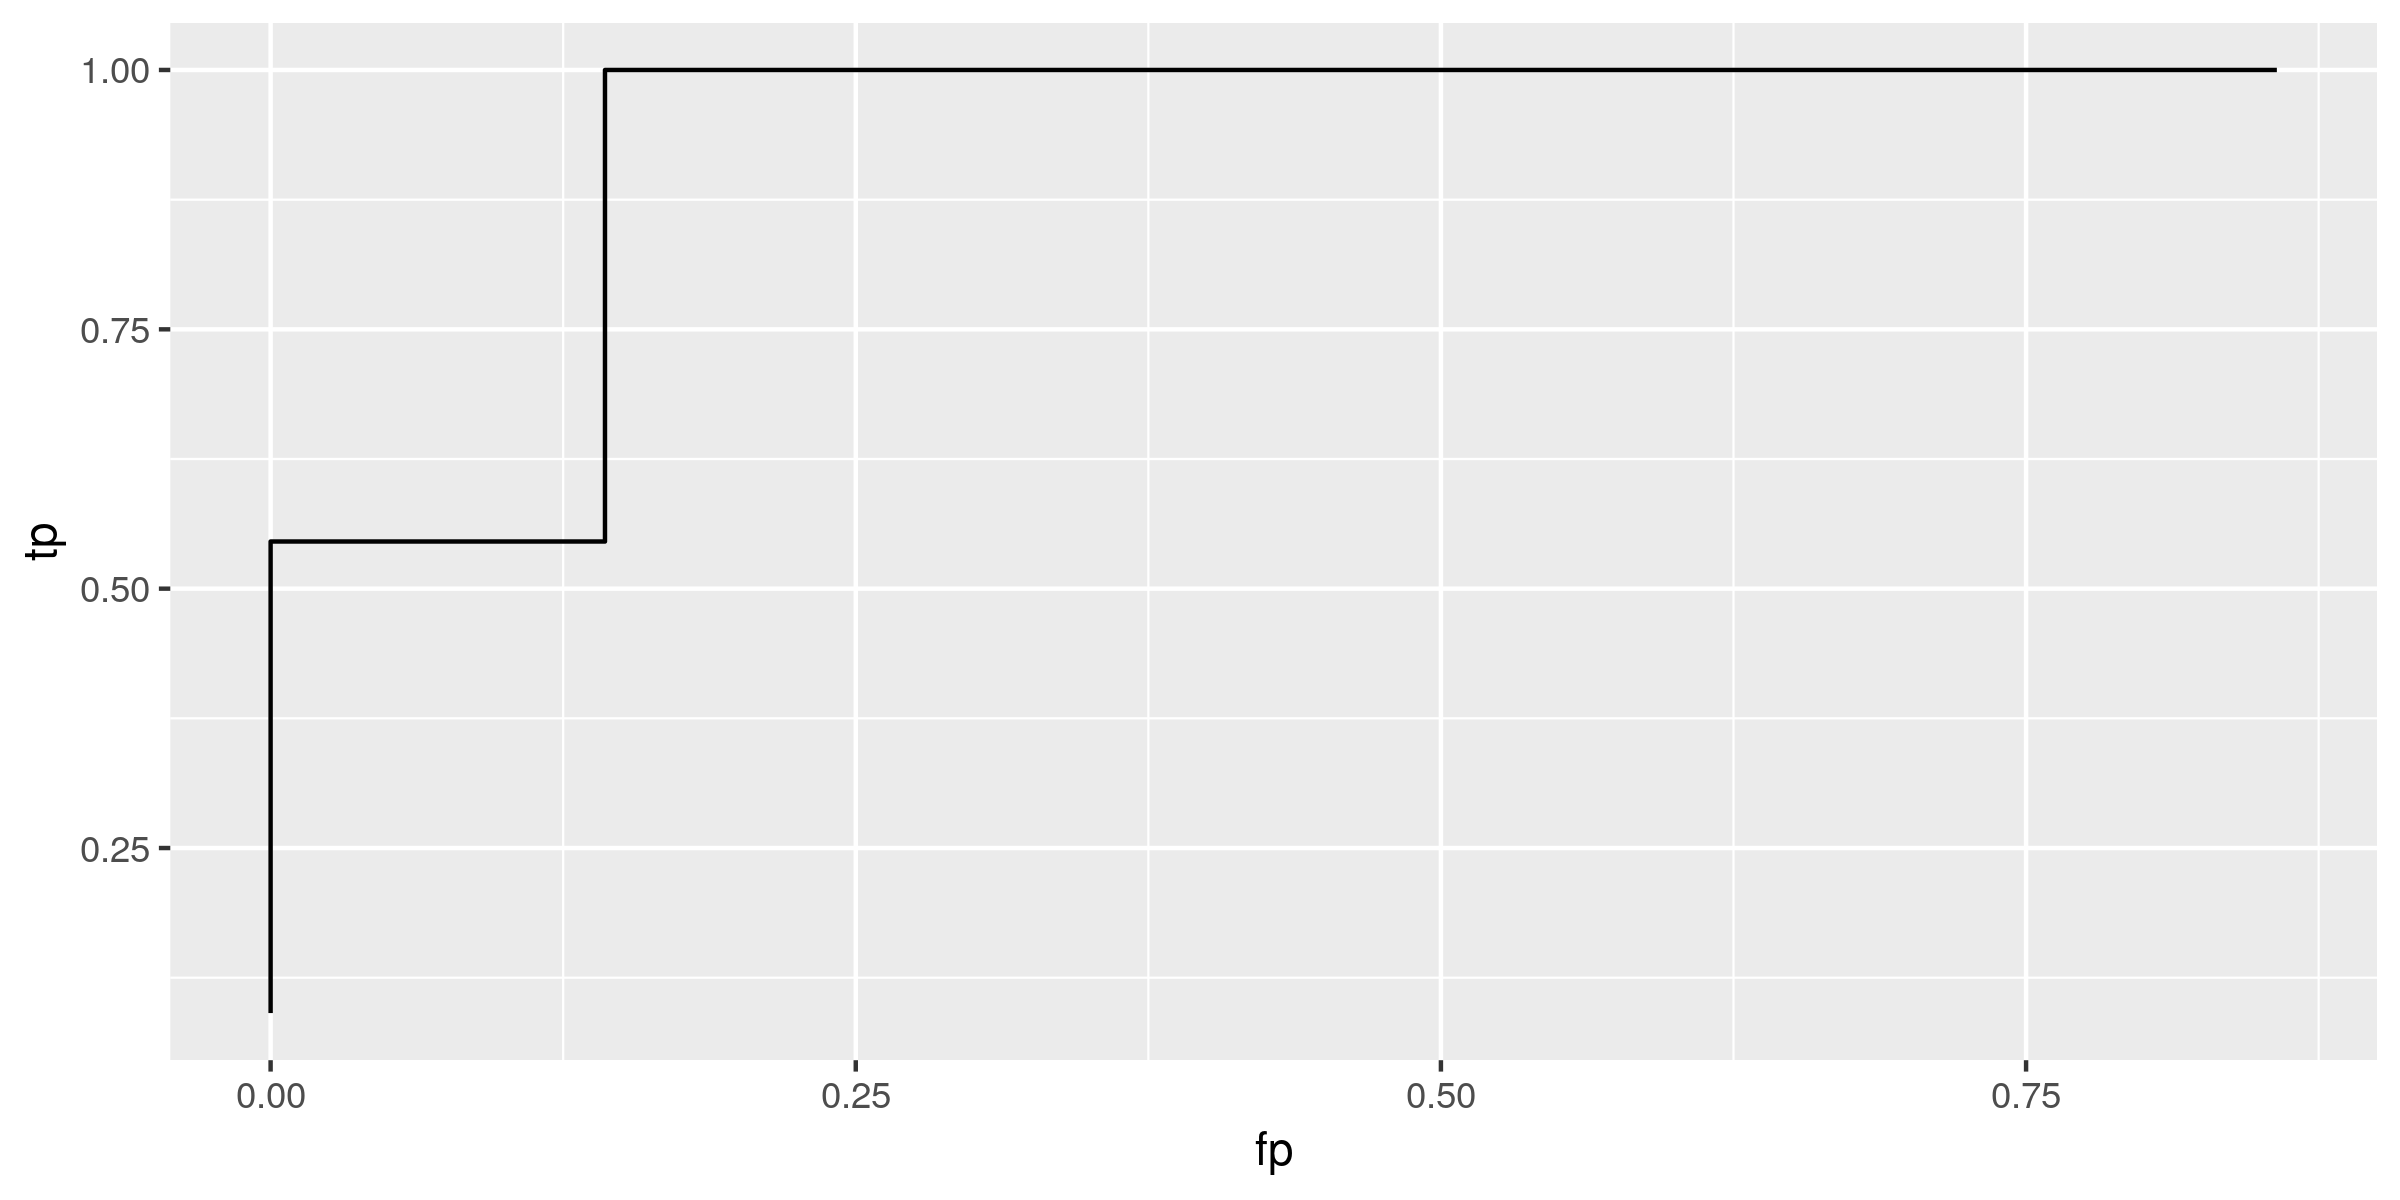

In [171]:
dfROC<-data.frame(th=unique(df_preds$pred),tp=NA,fp=NA,model="model1")

#for (th in seq(min(df_preds$pred),max(df_preds$pred),length.out=10)){
#    calctp_fp(df_preds$pred,df_preds$tipo_real,th=th)
#}
for (i in 1:nrow(dfROC)){
    v<-calctp_fp(df_preds$pred,df_preds$tipo_real,th=dfROC$th[i])
    dfROC$tp[i]<-v["tp"]
    dfROC$fp[i]<-v["fp"]
}
ggplot(data=dfROC,aes(x=fp,y=tp))+geom_path()

La curva ROC sale tan escalonada porque tenemos pocas muestras. Vamos a probar con un dataset más grande:

In [172]:
radar_big<-read.csv("data/radar.csv", stringsAsFactors = T)
radar_big$tipo<-relevel(radar_big$tipo,ref="ruido")

set.seed(123)
itrain<-sample(1:nrow(radar_big),round(nrow(radar_big)*0.7))
radar_big.train<- radar_big[itrain,]
radar_big.test <- radar_big[-itrain,]
summary(radar_big.train)
summary(radar_big.test)

       X            distancia        potencia           tipo    
 Min.   :   2.0   Min.   :  0.0   Min.   :0.000043   ruido:400  
 1st Qu.: 271.5   1st Qu.:110.0   1st Qu.:0.076630   avion:355  
 Median : 542.0   Median :210.0   Median :0.147003              
 Mean   : 894.0   Mean   :220.6   Mean   :0.155285              
 3rd Qu.: 900.5   3rd Qu.:324.5   3rd Qu.:0.235799              
 Max.   :6710.0   Max.   :500.0   Max.   :0.437188              

       X            distancia         potencia           tipo    
 Min.   :   1.0   Min.   :  0.00   Min.   :0.002404   ruido:178  
 1st Qu.: 263.2   1st Qu.: 88.75   1st Qu.:0.074041   avion:146  
 Median : 557.0   Median :196.50   Median :0.134573              
 Mean   : 909.5   Mean   :209.83   Mean   :0.150259              
 3rd Qu.: 876.2   3rd Qu.:313.25   3rd Qu.:0.226189              
 Max.   :7610.0   Max.   :498.00   Max.   :0.403745              

In [178]:
model_radar1<-glm(data=radar_big.train,formula=tipo~distancia+potencia,family=binomial(link='logit'))

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


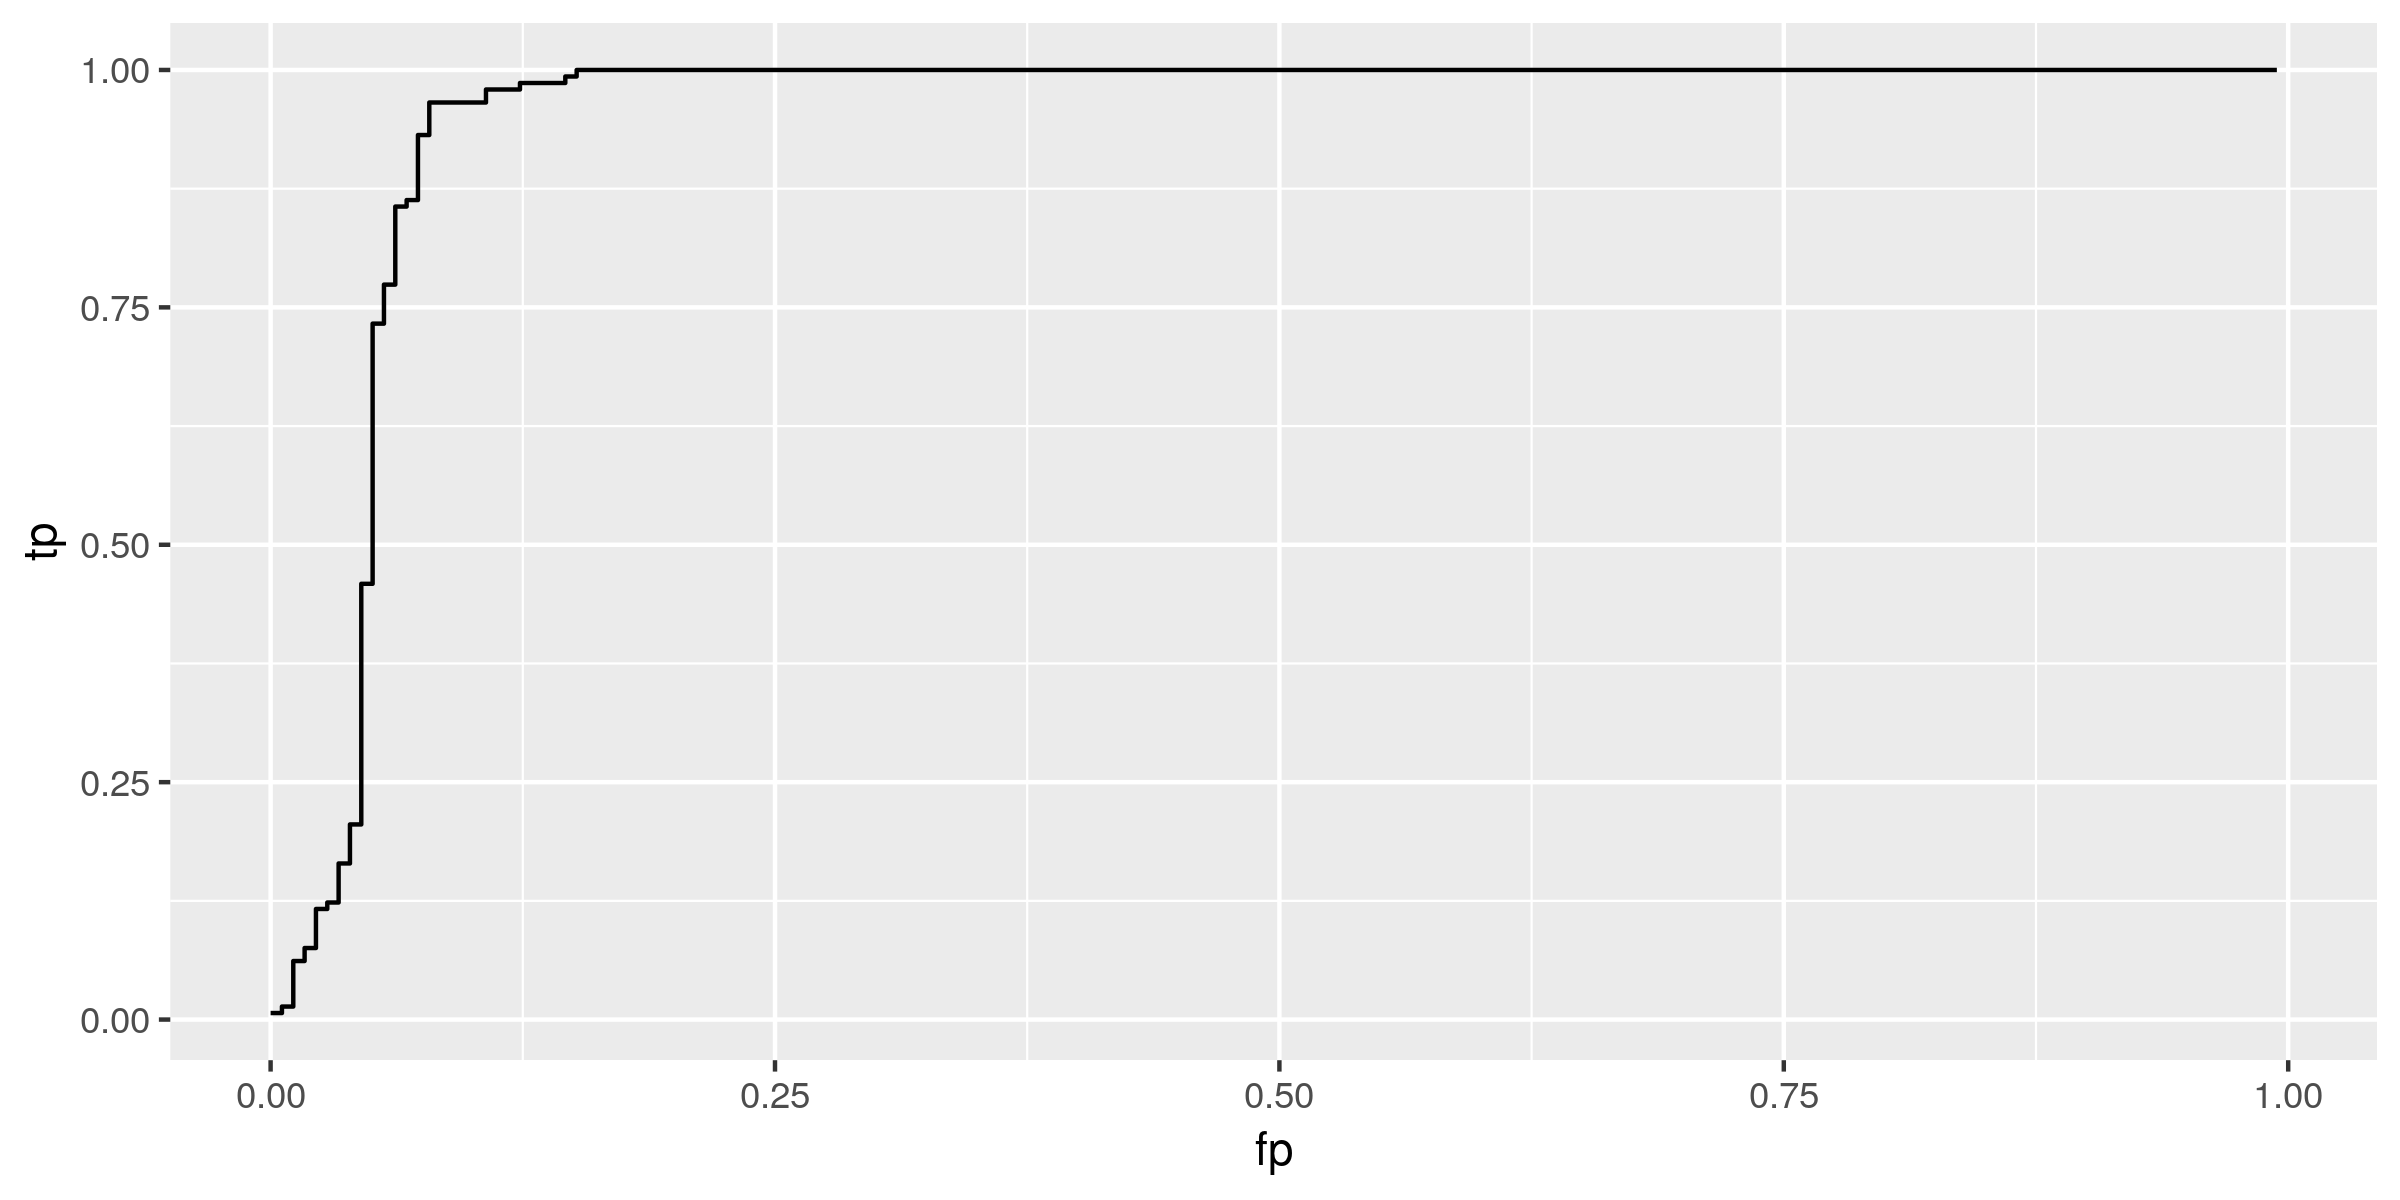

In [179]:

df_preds<-data.frame(pred=predict(model_radar1,radar_big.test),                     
                     tipo_real=radar_big.test$tipo)

dfROC<-data.frame(th=unique(df_preds$pred),tp=NA,fp=NA,model="model1")
dfROC<-dfROC[order(dfROC$th),]


for (i in 1:nrow(dfROC)){
    v<-calctp_fp(df_preds$pred,df_preds$tipo_real,th=dfROC$th[i])
    dfROC$tp[i]<-v["tp"]
    dfROC$fp[i]<-v["fp"]
}
ggplot(data=dfROC,aes(x=fp,y=tp))+geom_path()

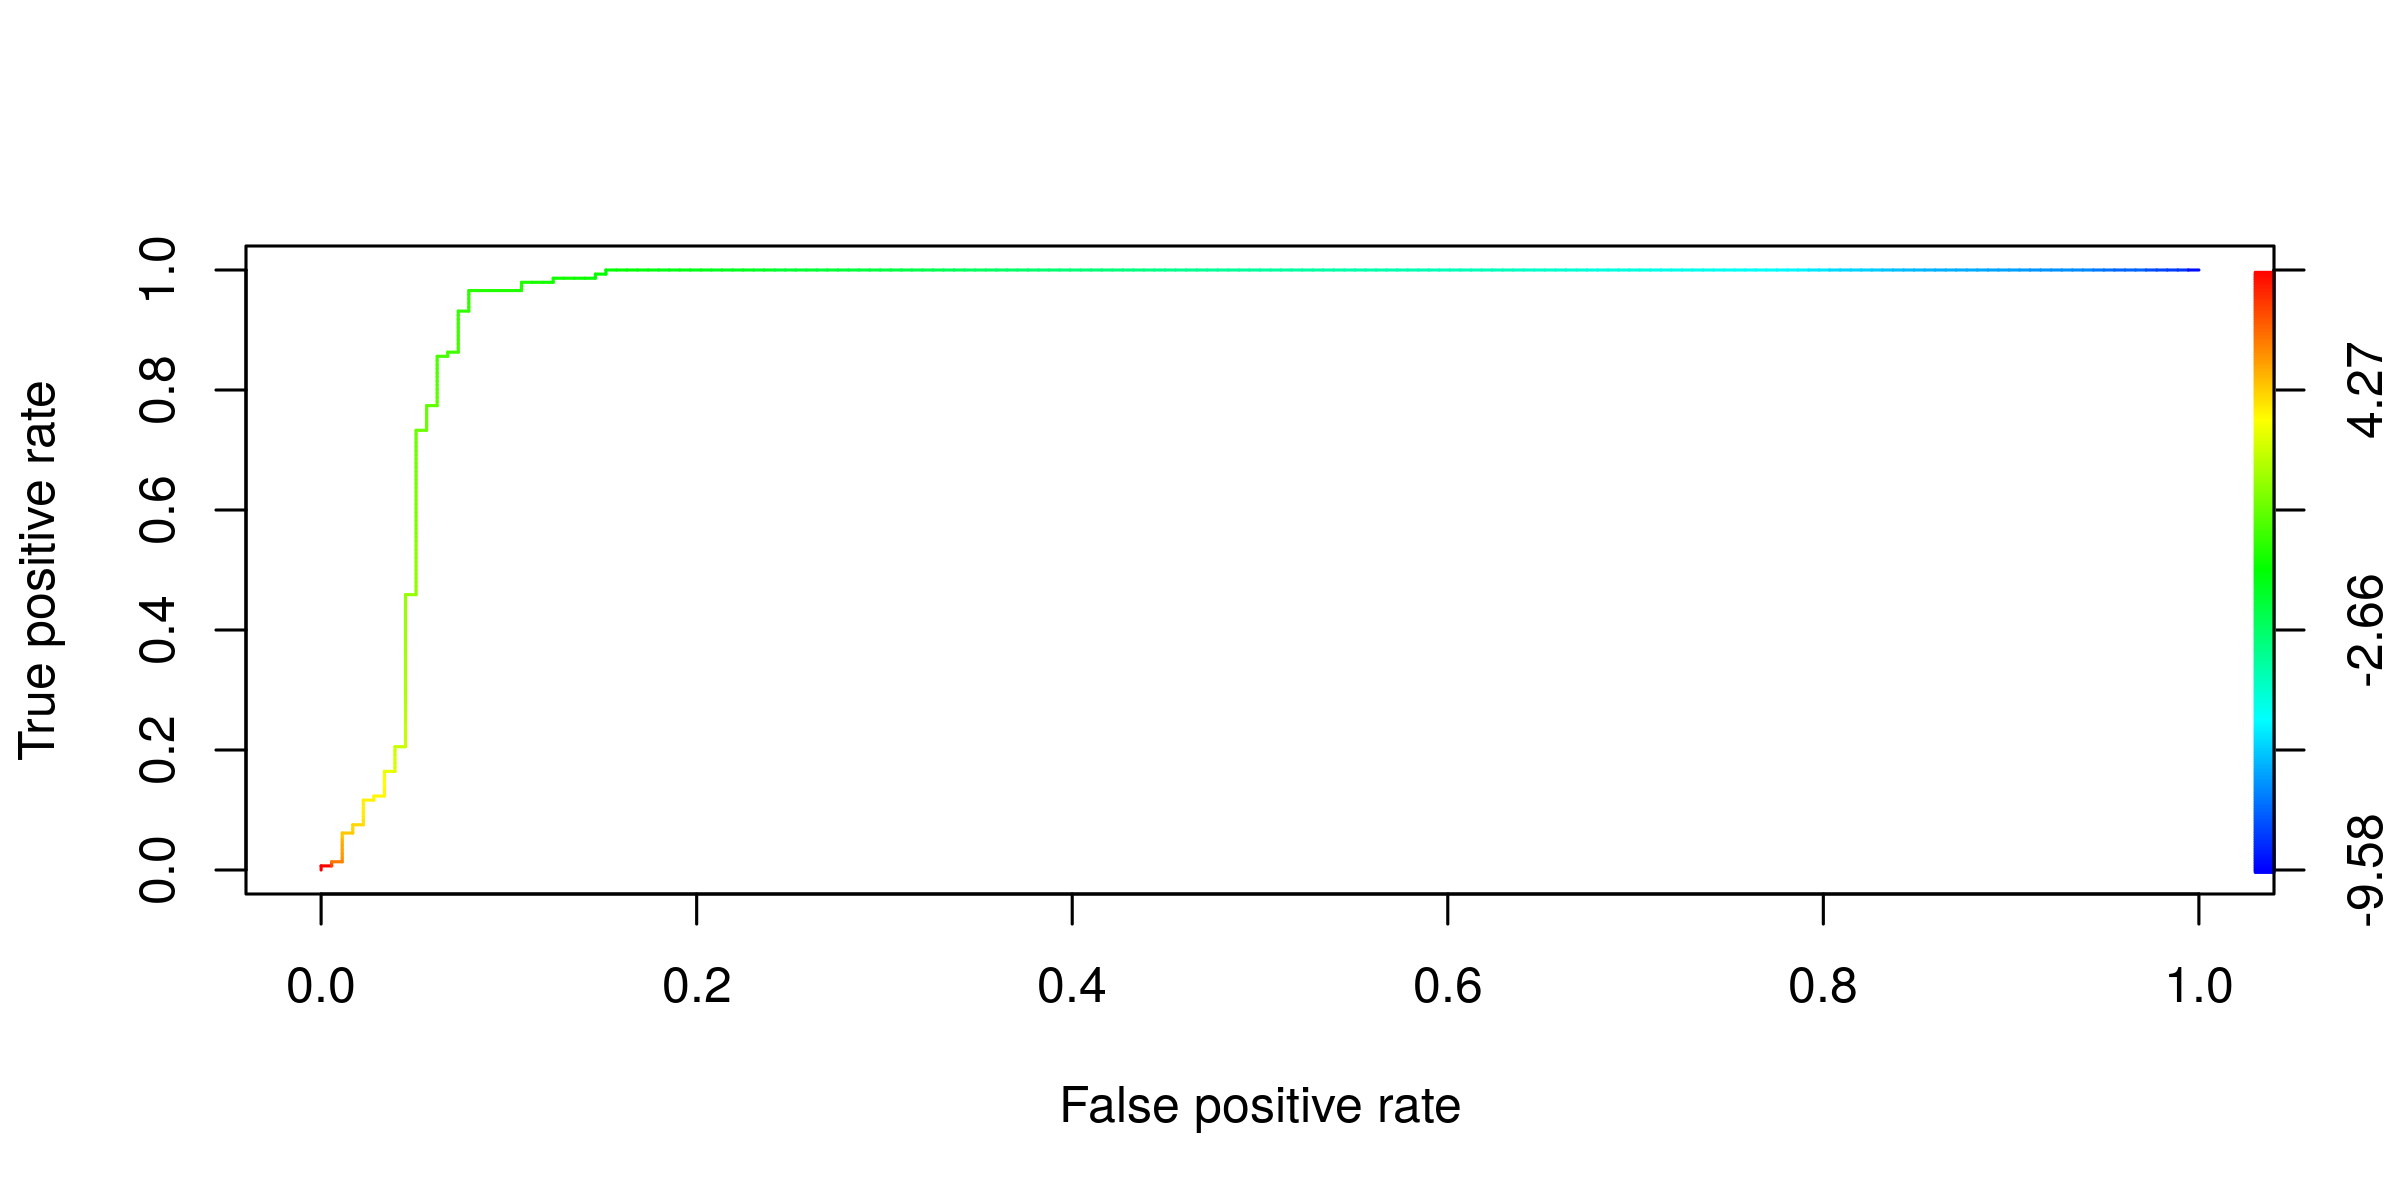

In [180]:
library(ROCR)

#p<-predict(model_radar1,radar_big.test,type="response")
p<-predict(model_radar1,radar_big.test)

pr <- prediction(p, radar_big.test$tipo,  label.ordering=c("ruido","avion"))
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf, colorize=TRUE)

In [181]:
model_radar2<-glm(data=radar_big.train,formula=tipo~I(distancia^2)+
                  potencia,family=binomial(link='logit'))
summary(model_radar2)


Call:
glm(formula = tipo ~ I(distancia^2) + potencia, family = binomial(link = "logit"), 
    data = radar_big.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0470  -0.2332  -0.0172   0.6096   1.1056  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.050e+01  9.113e-01  -11.53   <2e-16 ***
I(distancia^2)  4.215e-05  3.696e-06   11.40   <2e-16 ***
potencia        4.258e+01  3.487e+00   12.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1043.97  on 754  degrees of freedom
Residual deviance:  467.68  on 752  degrees of freedom
AIC: 473.68

Number of Fisher Scoring iterations: 7


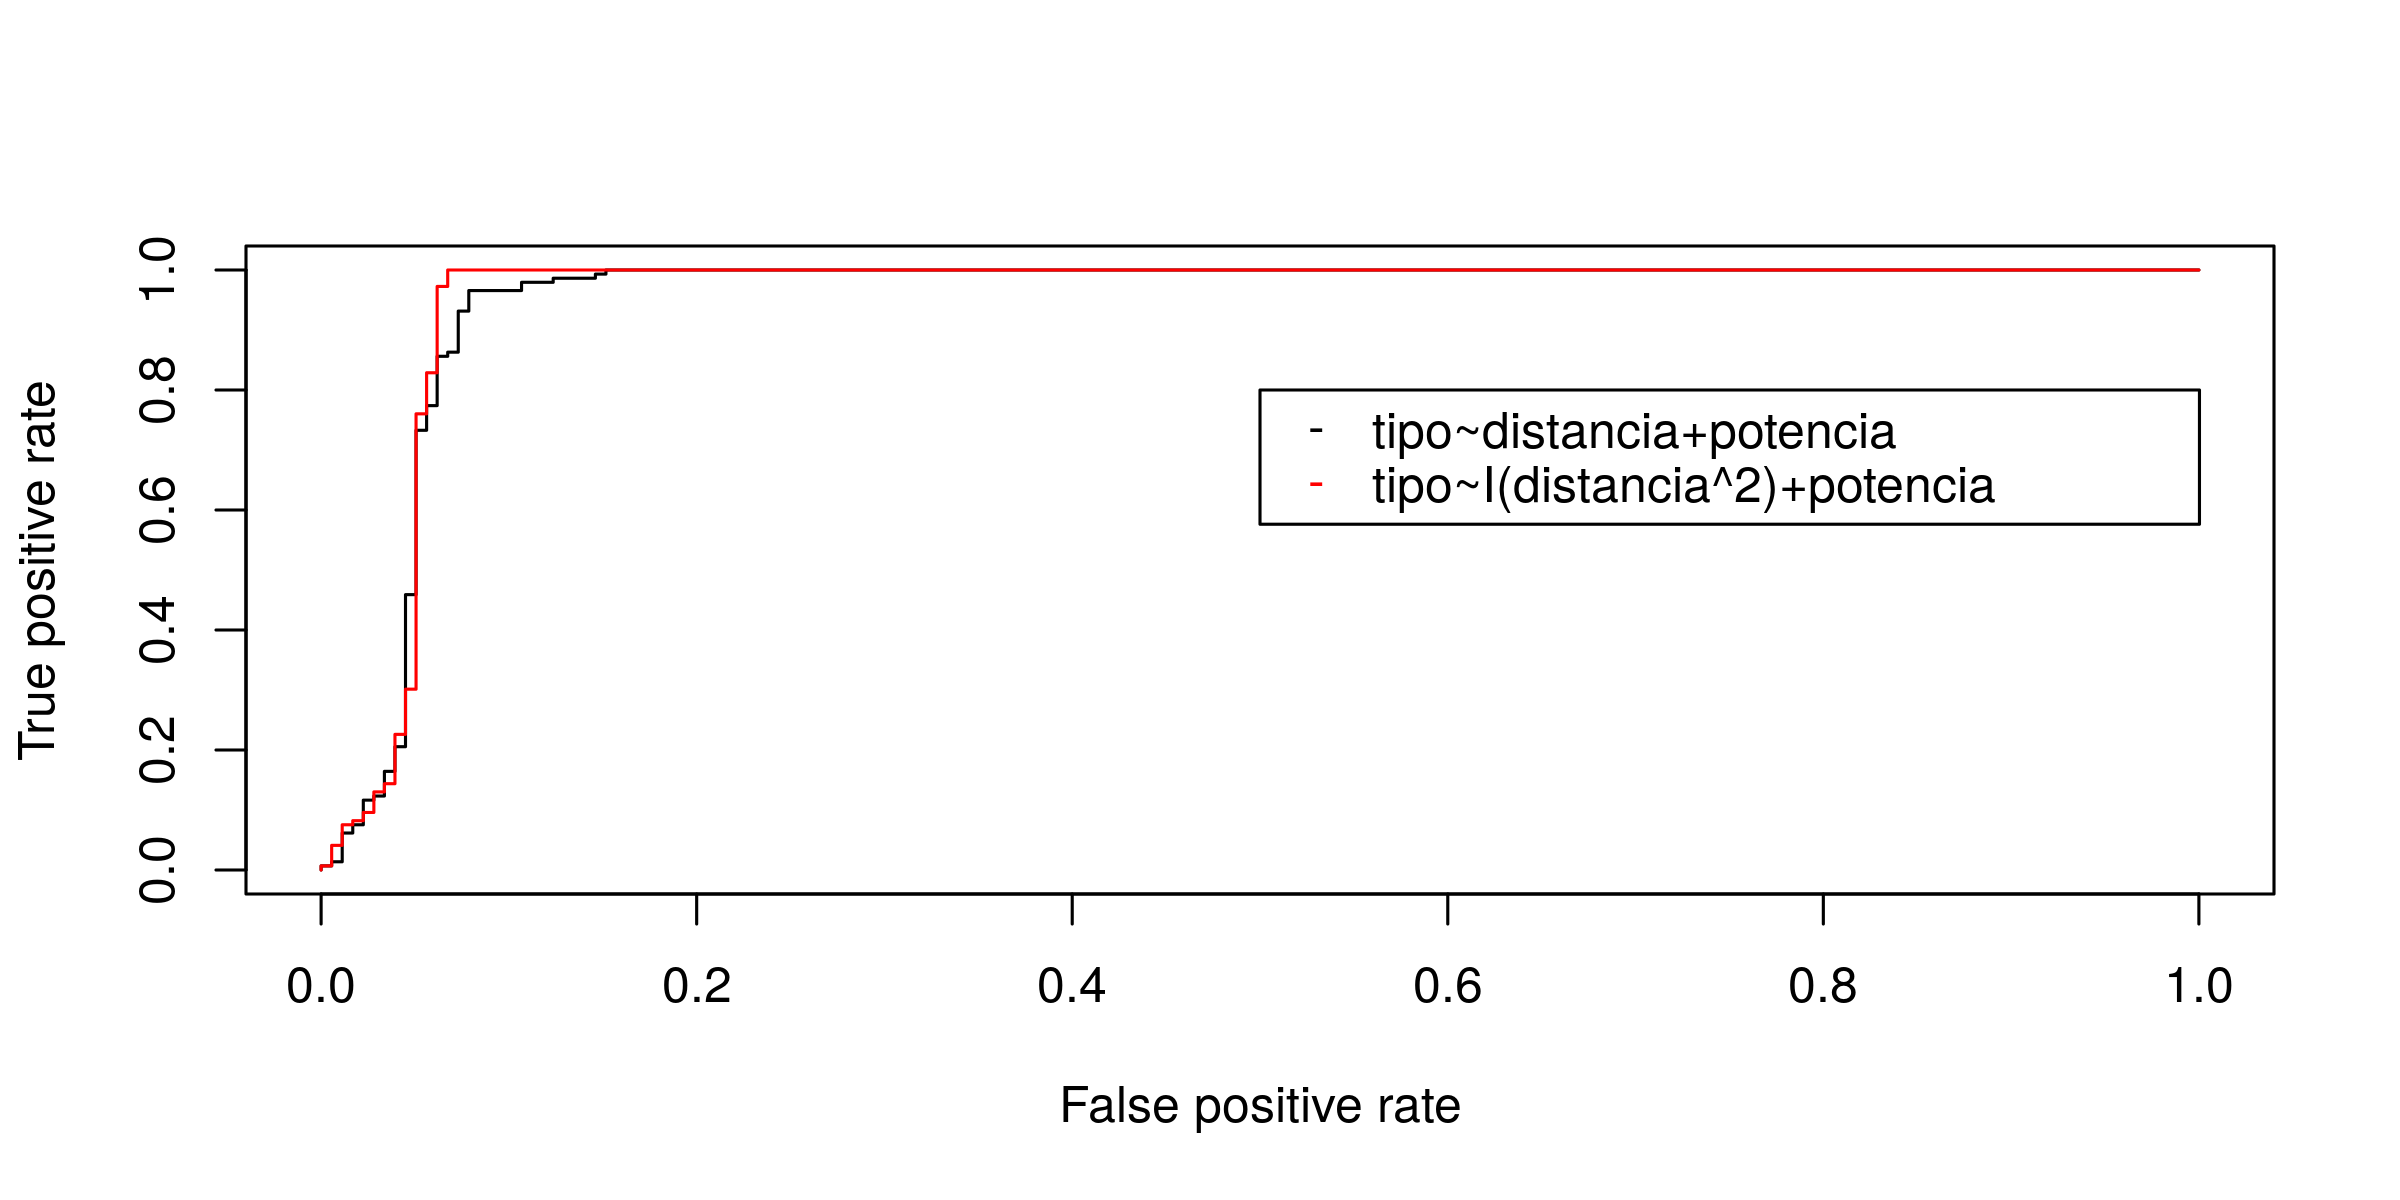

In [183]:
p<-predict(model_radar2,radar_big.test)
pr2 <- prediction(p, radar_big.test$tipo,label.ordering=c("ruido","avion"))
prf2 <- performance(pr2, measure = "tpr", x.measure = "fpr")

plot(prf) 
lines(prf2@x.values[[1]], prf2@y.values[[1]], col = 'red')
legend(0.5,0.8,c("tipo~distancia+potencia","tipo~I(distancia^2)+potencia"), pch=c("-","-"),col=c("black","red"), y.intersp = 2)

In [289]:
?performance

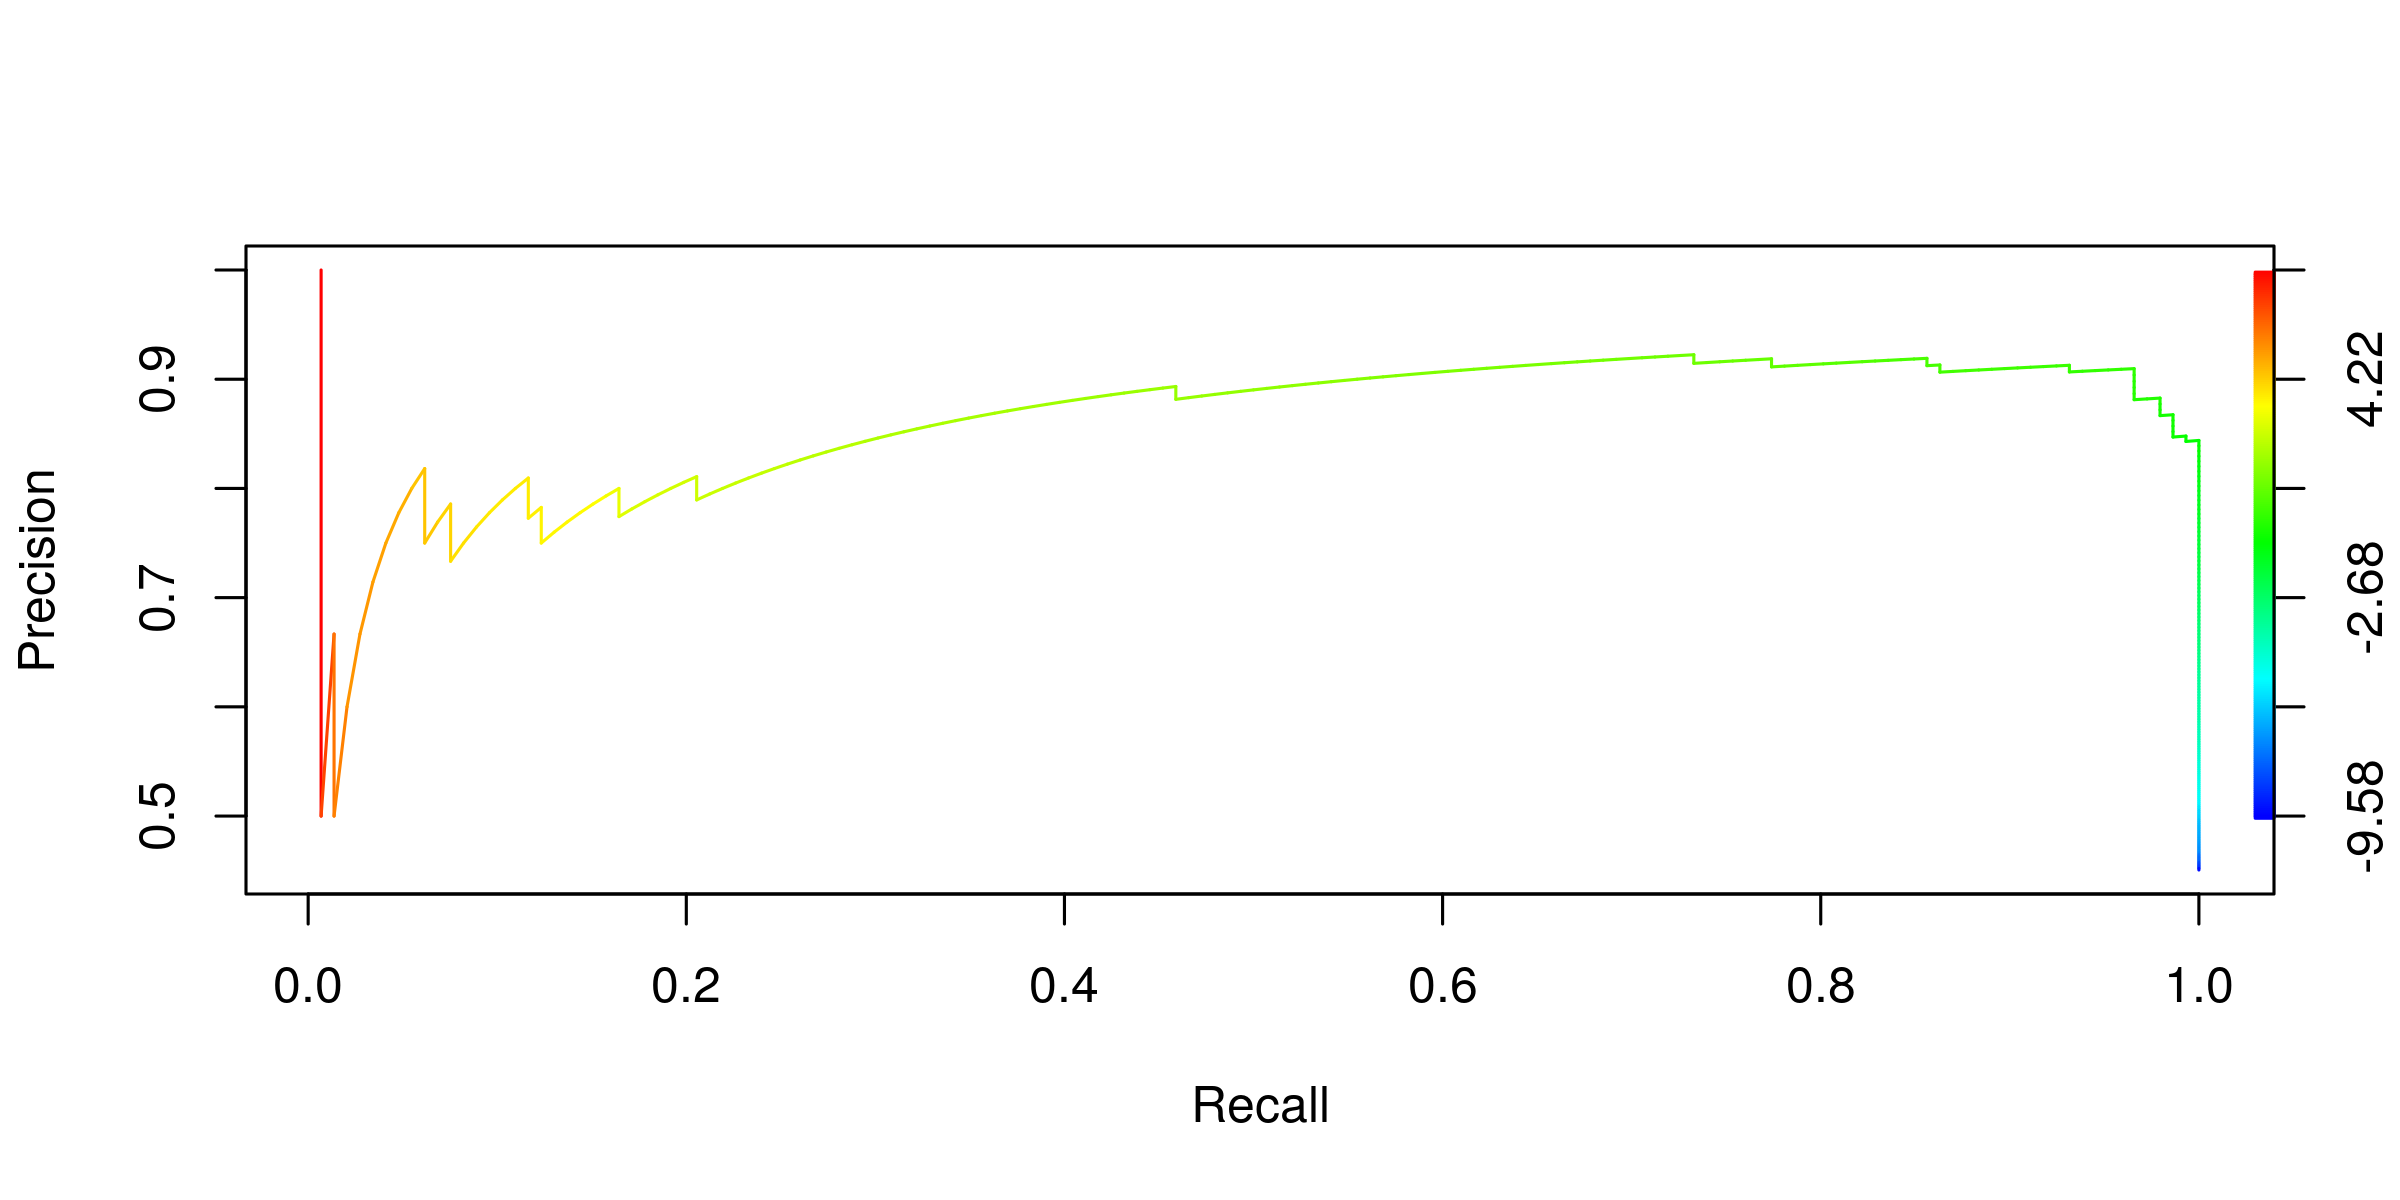

In [185]:
prf <- performance(pr, measure = "prec", x.measure = "rec", label.ordering=c("ruido","avion"))
plot(prf,colorize=TRUE)

### AUC

Area bajo la curva (Area Under The Curve), número entre 0 y 1 que mide como de bueno es un clasificador. 

Es el area bajo la curva ROC, cuando su valor es:
* 1 significa que el clasificador es perfecto
* 0.5 significa que la elección es tan buena como hacerla al azar
* Menor de 0.5, significa que lo estamos haciendo peor que el azar

In [213]:
pauc1<-performance(pr, measure = "auc", label.ordering=c("ruido","avion"))
pauc1@y.values[[1]]

[1] 0.9499384

In [214]:
pauc2<-performance(pr2, measure = "auc", label.ordering=c("ruido","avion"))
pauc2@y.values[[1]]

[1] 0.9531707

Setting levels: control = ruido, case = avion

Setting direction: controls < cases



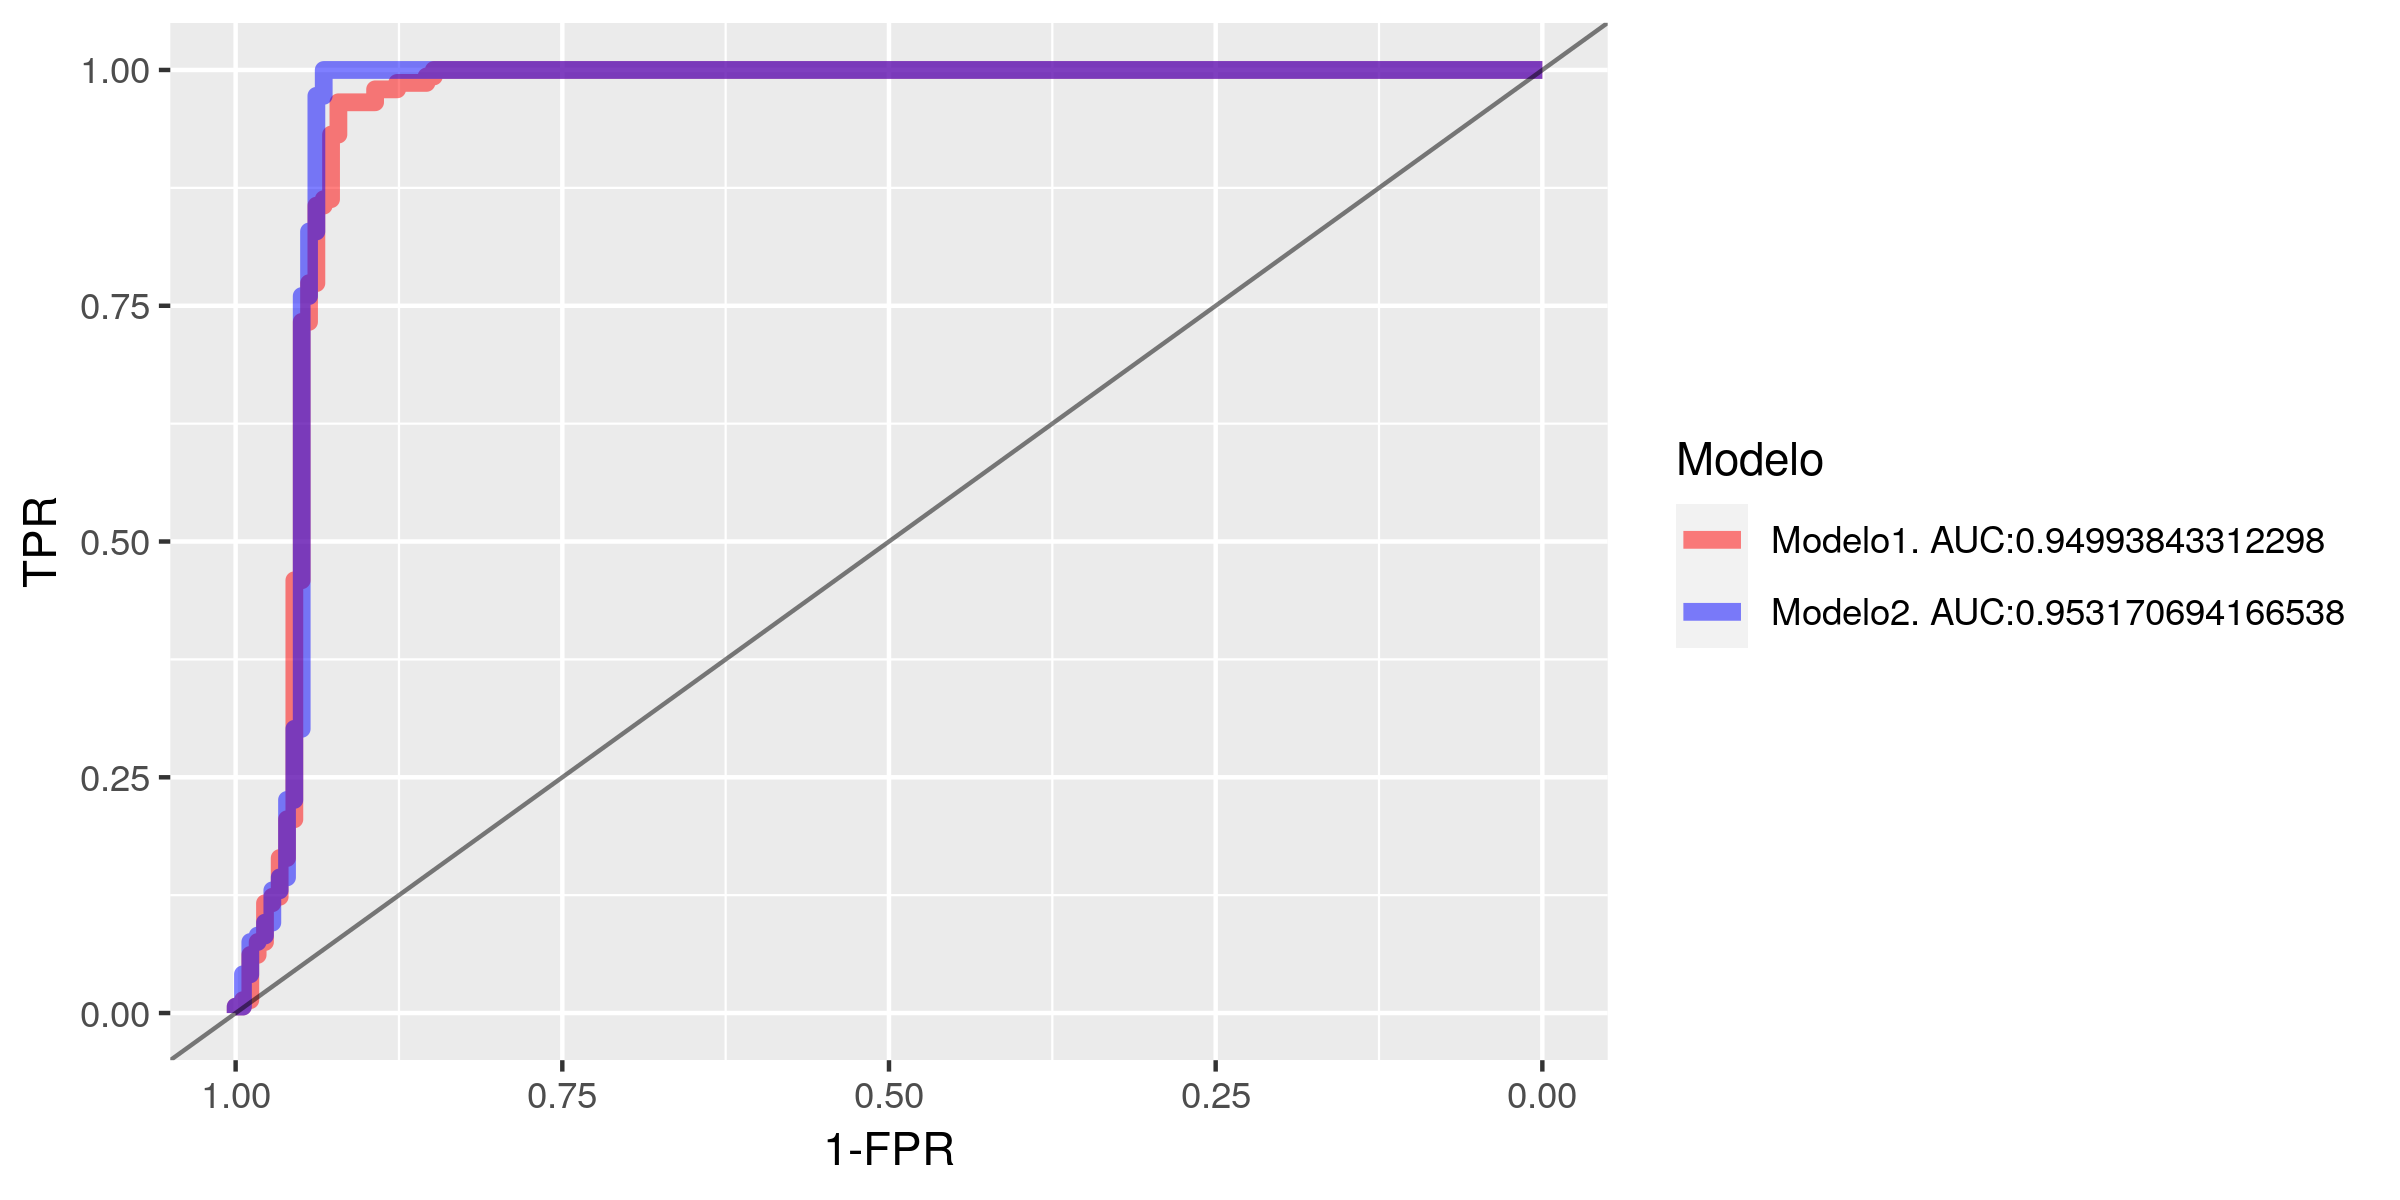

In [215]:
#library(pROC)
rocobj1 <- pROC::roc(
    radar_big.test$tipo,
    predict(model_radar1,radar_big.test))

rocobj2 <- pROC::roc(
    radar_big.test$tipo,
    predict(model_radar2,radar_big.test),
    levels=c("ruido","avion"),direction="<")


#plot(rocobj1, print.auc = TRUE, col = "blue")
#plot(rocobj2, print.auc = TRUE, col = "green", print.auc.y = .4, add = TRUE)

pROC::ggroc(list(model1=rocobj1, model2=rocobj2), alpha = 0.5, size = 2)+ xlab("1-FPR") + ylab("TPR") +
geom_abline(slope = 1 ,intercept = 1, alpha=0.5) +
  scale_colour_manual(values = c("red",  "#0000FF") ,name="Modelo", 
                      labels=c(paste0("Modelo1. AUC:",pROC::auc(rocobj1)),
                               paste0("Modelo2. AUC:",pROC::auc(rocobj2))))

#### Ejemplo

Este conjunto de datos contiene información sobre los resultados del tratamiento de verrugas de 90 pacientes que utilizan crioterapia.

https://archive.ics.uci.edu/ml/datasets/Cryotherapy+Dataset+


In [216]:
cryo<-read.csv('data/Cryotherapy.csv')
cryo$sex<-factor(cryo$sex,labels=c("Mujer","Hombre"))
cryo$Type<-factor(cryo$Type,labels=c("Común","Plantar","Ambas"))
cryo$Result_of_Treatment<-factor(cryo$Result_of_Treatment,labels=c("No","Si"))
summary(cryo)

     sex          age            Time        Number_of_Warts       Type   
 Mujer :47   Min.   :15.0   Min.   : 0.250   Min.   : 1.000   Común  :54  
 Hombre:43   1st Qu.:18.0   1st Qu.: 4.562   1st Qu.: 2.000   Plantar: 9  
             Median :25.5   Median : 8.500   Median : 5.000   Ambas  :27  
             Mean   :28.6   Mean   : 7.667   Mean   : 5.511               
             3rd Qu.:35.0   3rd Qu.:10.688   3rd Qu.: 8.000               
             Max.   :67.0   Max.   :12.000   Max.   :12.000               
      Area        Result_of_Treatment
 Min.   :  4.00   No:42              
 1st Qu.: 20.00   Si:48              
 Median : 70.00                      
 Mean   : 85.83                      
 3rd Qu.:100.00                      
 Max.   :750.00                      

In [248]:
set.seed(0)
num_train=round(0.7*nrow(cryo))
train_ind<-sample(1:nrow(cryo),size = num_train)

cryo.train=cryo[train_ind,]
cryo.test =cryo[-train_ind,]
summary(cryo.train)
summary(cryo.test)

     sex          age            Time        Number_of_Warts      Type   
 Mujer :31   Min.   :15.0   Min.   : 0.500   Min.   : 1.00   Común  :38  
 Hombre:32   1st Qu.:18.0   1st Qu.: 4.625   1st Qu.: 3.00   Plantar: 7  
             Median :24.0   Median : 8.500   Median : 5.00   Ambas  :18  
             Mean   :28.3   Mean   : 7.683   Mean   : 5.73               
             3rd Qu.:35.0   3rd Qu.:10.750   3rd Qu.: 8.50               
             Max.   :67.0   Max.   :12.000   Max.   :12.00               
      Area        Result_of_Treatment
 Min.   :  4.00   No:29              
 1st Qu.: 20.00   Si:34              
 Median : 70.00                      
 Mean   : 74.25                      
 3rd Qu.: 96.00                      
 Max.   :750.00                      

     sex          age            Time       Number_of_Warts      Type   
 Mujer :16   Min.   :15.0   Min.   : 0.25   Min.   : 1      Común  :16  
 Hombre:11   1st Qu.:18.5   1st Qu.: 4.75   1st Qu.: 2      Plantar: 2  
             Median :27.0   Median : 8.75   Median : 4      Ambas  : 9  
             Mean   :29.3   Mean   : 7.63   Mean   : 5                  
             3rd Qu.:34.0   3rd Qu.:10.50   3rd Qu.: 7                  
             Max.   :67.0   Max.   :12.00   Max.   :12                  
      Area       Result_of_Treatment
 Min.   :  6.0   No:13              
 1st Qu.: 20.0   Si:14              
 Median : 63.0                      
 Mean   :112.9                      
 3rd Qu.:107.5                      
 Max.   :750.0                      

In [249]:
model<-glm(data=cryo.train,formula=Result_of_Treatment~.,family=binomial())

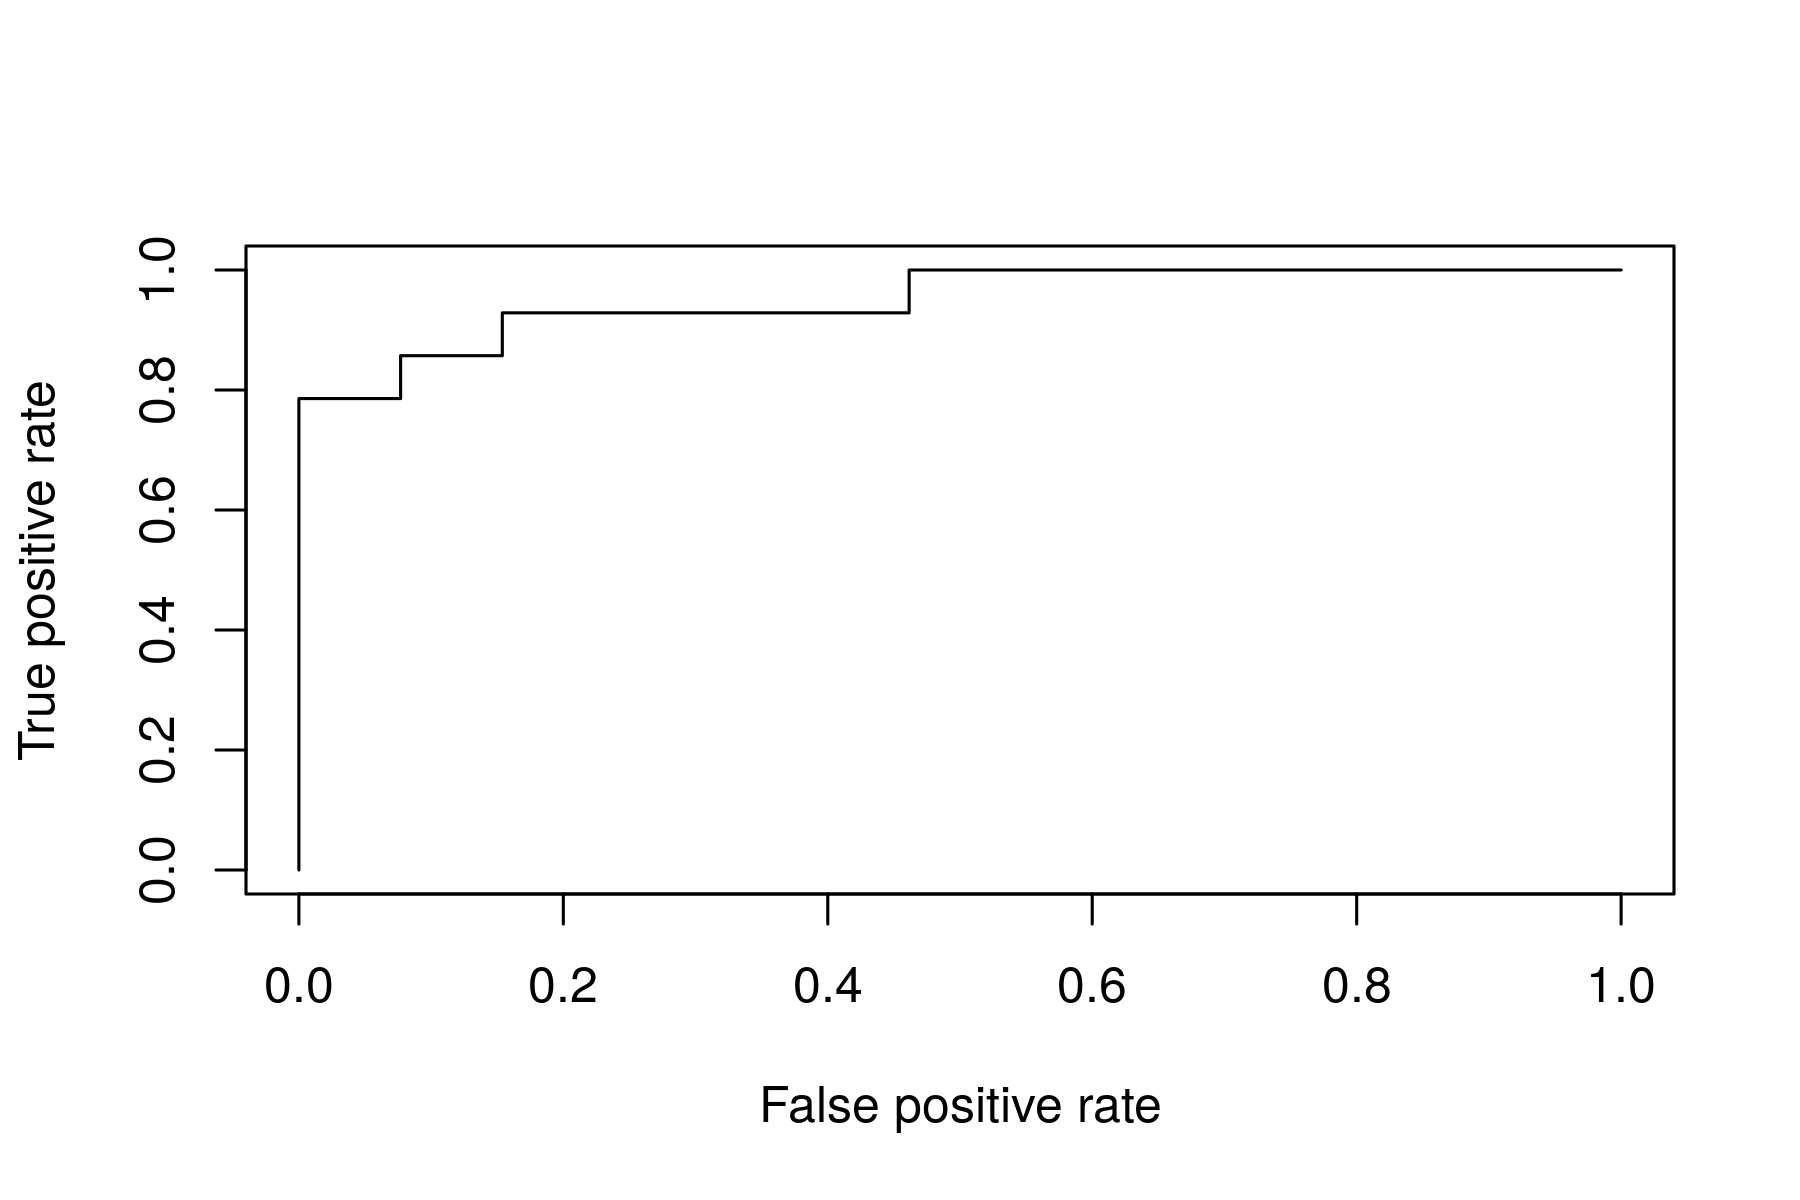

In [250]:
library(ROCR)
options(repr.plot.height=4,repr.plot.width=6)


p<-predict(model,cryo.test,type="response")

pr <- prediction(p, cryo.test$Result_of_Treatment)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf)

In [251]:
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

[1] "The AUC is 0.950549450549451"

In [252]:
summary(model)


Call:
glm(formula = Result_of_Treatment ~ ., family = binomial(), data = cryo.train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.43471  -0.02699   0.00203   0.07035   1.65953  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)   
(Intercept)     22.36121    8.53599   2.620   0.0088 **
sexHombre       -3.97297    2.23113  -1.781   0.0750 . 
age             -0.21982    0.09163  -2.399   0.0164 * 
Time            -1.73334    0.70655  -2.453   0.0142 * 
Number_of_Warts  0.01275    0.23255   0.055   0.9563   
TypePlantar      2.19927    2.41122   0.912   0.3617   
TypeAmbas       -7.10649    5.51485  -1.289   0.1975   
Area             0.01671    0.01360   1.228   0.2193   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 86.939  on 62  degrees of freedom
Residual deviance: 12.293  on 55  degrees of freedom
AIC: 28.293

Number of Fisher Scoring i

In [253]:
library(MASS)
stepAIC(model)

Start:  AIC=28.29
Result_of_Treatment ~ sex + age + Time + Number_of_Warts + Type + 
    Area

                  Df Deviance    AIC
- Number_of_Warts  1   12.296 26.296
- Area             1   13.181 27.181
<none>                 12.293 28.293
- Type             2   18.846 30.846
- sex              1   18.057 32.057
- age              1   29.496 43.496
- Time             1   51.175 65.175

Step:  AIC=26.3
Result_of_Treatment ~ sex + age + Time + Type + Area

       Df Deviance    AIC
- Area  1   13.215 25.215
<none>      12.296 26.296
- Type  2   19.057 29.057
- sex   1   18.323 30.323
- age   1   29.727 41.727
- Time  1   51.190 63.190

Step:  AIC=25.21
Result_of_Treatment ~ sex + age + Time + Type

       Df Deviance    AIC
<none>      13.215 25.215
- Type  2   19.699 27.699
- sex   1   18.659 28.659
- age   1   31.305 41.305
- Time  1   51.702 61.702



Call:  glm(formula = Result_of_Treatment ~ sex + age + Time + Type, 
    family = binomial(), data = cryo.train)

Coefficients:
(Intercept)    sexHombre          age         Time  TypePlantar    TypeAmbas  
    23.0784      -3.4471      -0.2209      -1.7479       2.4783      -7.0159  

Degrees of Freedom: 62 Total (i.e. Null);  57 Residual
Null Deviance:	    86.94 
Residual Deviance: 13.21 	AIC: 25.21

In [254]:
model<-glm(data=cryo.train,formula=Result_of_Treatment~ age + Time + Type,family=binomial())
summary(model)


Call:
glm(formula = Result_of_Treatment ~ age + Time + Type, family = binomial(), 
    data = cryo.train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.98724  -0.05137   0.00526   0.05525   2.07469  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) 19.88831    7.19475   2.764  0.00570 **
age         -0.21789    0.09689  -2.249  0.02453 * 
Time        -1.55234    0.57641  -2.693  0.00708 **
TypePlantar  2.15700    1.61272   1.337  0.18106   
TypeAmbas   -6.40336    6.37287  -1.005  0.31500   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 86.939  on 62  degrees of freedom
Residual deviance: 18.659  on 58  degrees of freedom
AIC: 28.659

Number of Fisher Scoring iterations: 9


In [255]:
p<-predict(model,cryo.test,type="response")

pr <- prediction(p, cryo.test$Result_of_Treatment)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

[1] "The AUC is 0.972527472527473"

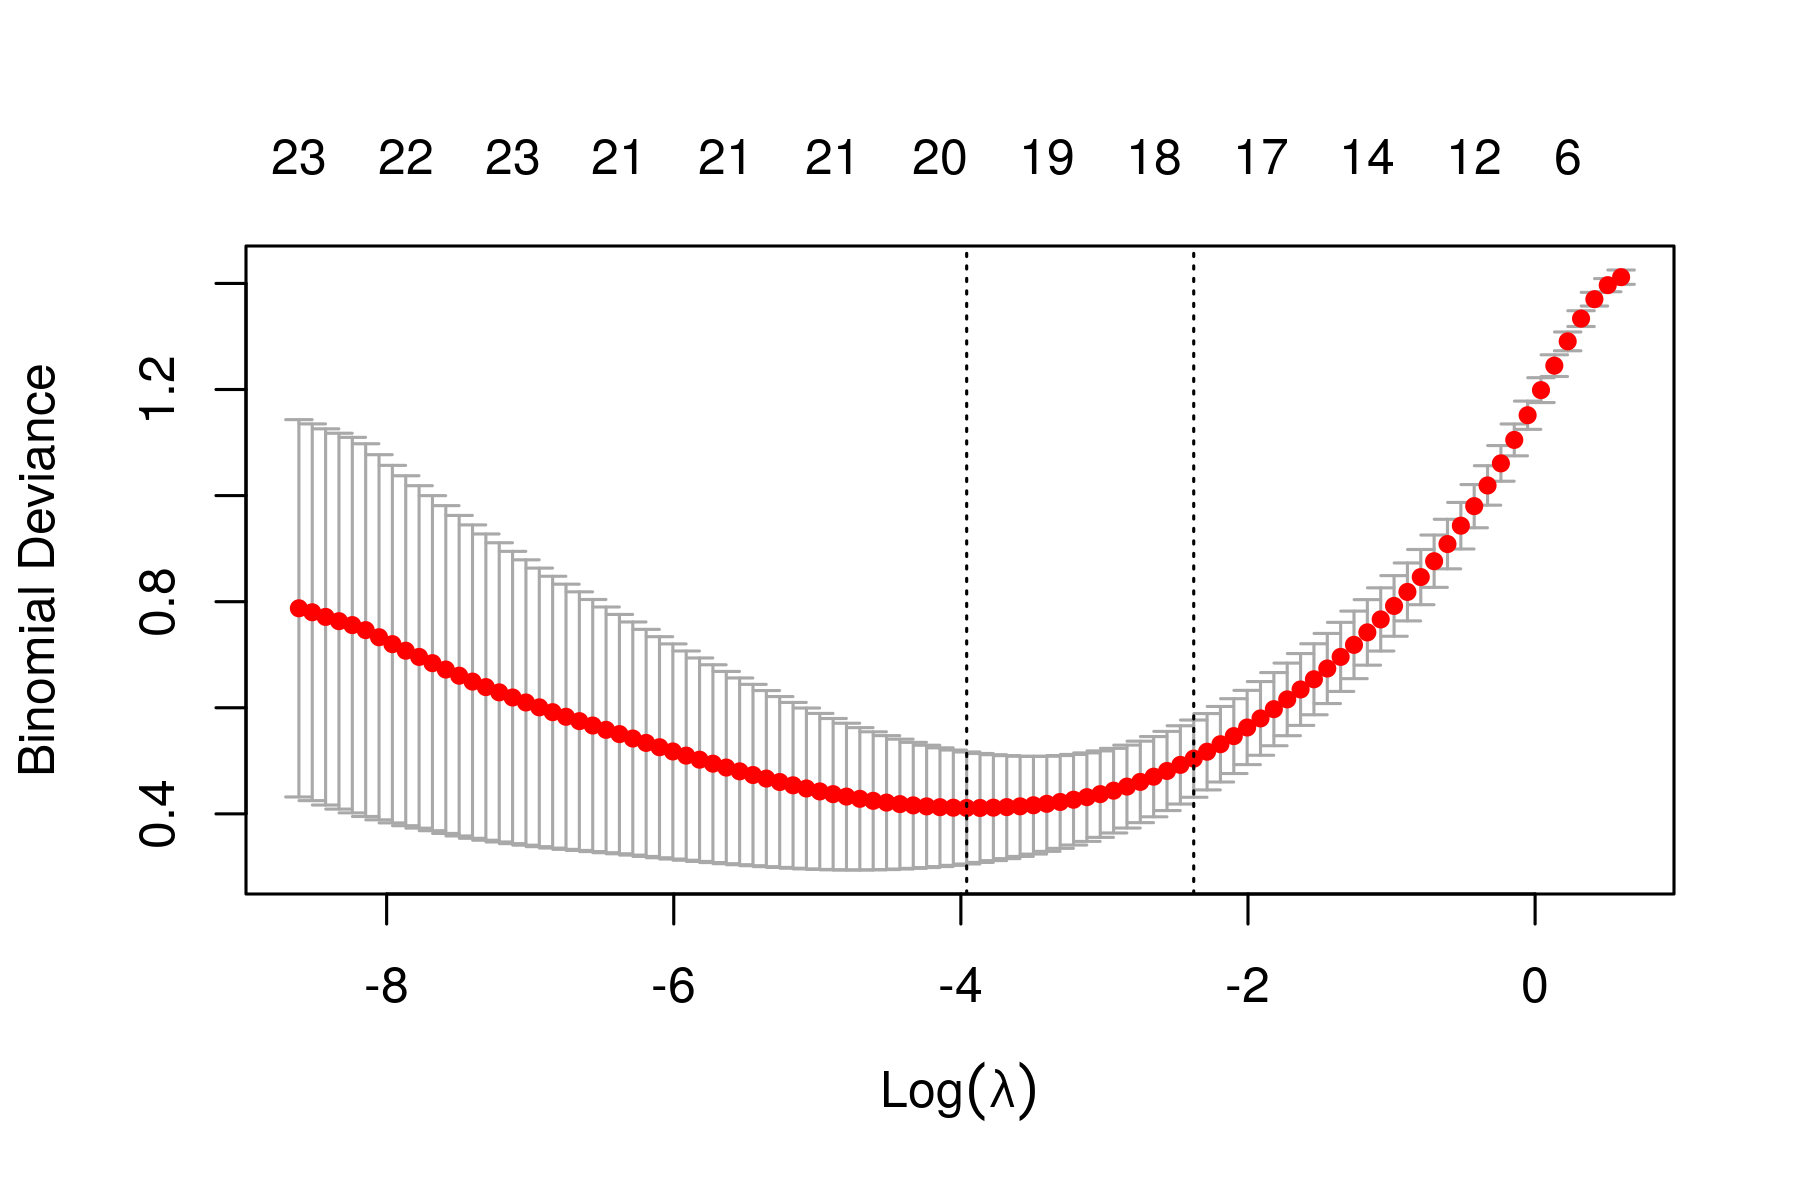

In [267]:

cvfit<-glmnetUtils::cv.glmnet(Result_of_Treatment~.+age*Time*Type+I(age^2)+I(Time^2),
                              family = "binomial",
                              data=cryo.train,nfolds=10,alpha=0.2)
plot(cvfit)

In [268]:
p<-predict(cvfit,newdata=cryo.test,s=cvfit$lambda.min)

pr <- prediction(p, cryo.test$Result_of_Treatment)
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

[1] "The AUC is 0.961538461538462"

### Churn rate

Vamos a utilizar un dataset publicado por IBM en [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn).


En este ejemplo vamos a cargar el dataset proporcionado y ver si somos capaces de ver qué usuarios son los que corren más riesgo de irse.

El conjunto de datos incluye información sobre:

* Clientes que se fueron en el último mes: la columna se llama Churn
* Servicios para los que se ha registrado cada cliente: teléfono, líneas múltiples, Internet, seguridad en línea, copia de seguridad en línea, protección de dispositivos, soporte técnico y transmisión de TV y películas
* Información de la cuenta del cliente: cuánto tiempo han sido cliente (columna tenure), contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales
* Información demográfica sobre los clientes: sexo, rango de edad y si tienen socios y dependientes


In [1]:
dfchurn<-read.csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv", stringsAsFactors = T)
head(dfchurn)
str(dfchurn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [2]:
dfchurn$OnlineSecurity<-NULL
dfchurn$OnlineBackup<-NULL
dfchurn$DeviceProtection<-NULL
dfchurn$TechSupport<-NULL
dfchurn$StreamingTV<-NULL
dfchurn$StreamingMovies<-NULL

In [3]:
summary(dfchurn)

      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

Vemos que la mayor parte de las columnas son factores. Llama la atención la columna SeniorCitizen que parece numérica, veamos que valores tiene:

In [4]:
unique(dfchurn$SeniorCitizen)
table(dfchurn$SeniorCitizen)

[1] 0 1


   0    1 
5901 1142 

Esta columna debería ser un factor, mirando otra parte de la documentación vemos que:

 1 = Si es senior citizen
 
 0 = No es senior citizen

In [5]:
dfchurn$SeniorCitizen<-factor(dfchurn$SeniorCitizen,labels = c("No","Yes"))

Eliminamos la columna customerID porque no nos hace falta

In [6]:
dfchurn$customerID<-NULL

In [7]:
set.seed(12)
idx<-sample(1:nrow(dfchurn),0.7*nrow(dfchurn))
dfchurn.train<-dfchurn[idx,]
dfchurn.test<-dfchurn[-idx,]

In [8]:
summary(dfchurn.train)

    gender     SeniorCitizen Partner    Dependents     tenure      PhoneService
 Female:2486   No :4134      No :2540   No :3443   Min.   : 0.00   No : 465    
 Male  :2444   Yes: 796      Yes:2390   Yes:1487   1st Qu.: 9.00   Yes:4465    
                                                   Median :29.00               
                                                   Mean   :32.21               
                                                   3rd Qu.:55.00               
                                                   Max.   :72.00               
                                                                               
          MultipleLines     InternetService           Contract   
 No              :2399   DSL        :1678   Month-to-month:2723  
 No phone service: 465   Fiber optic:2167   One year      :1032  
 Yes             :2066   No         :1085   Two year      :1175  
                                                                 
                              

In [9]:
model<-glm(data=dfchurn.train,formula=Churn~.,family=binomial())
summary(model)


Call:
glm(formula = Churn ~ ., family = binomial(), data = dfchurn.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8100  -0.6887  -0.2836   0.7480   3.5131  

Coefficients: (1 not defined because of singularities)
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -8.890e-02  2.740e-01  -0.324 0.745594    
genderMale                            4.265e-02  7.697e-02   0.554 0.579522    
SeniorCitizenYes                      2.584e-01  9.993e-02   2.586 0.009723 ** 
PartnerYes                            3.175e-02  9.189e-02   0.346 0.729687    
DependentsYes                        -2.512e-01  1.065e-01  -2.358 0.018397 *  
tenure                               -6.152e-02  7.527e-03  -8.173 3.01e-16 ***
PhoneServiceYes                      -6.803e-01  1.753e-01  -3.881 0.000104 ***
MultipleLinesNo phone service                NA         NA      NA       NA    
MultipleLinesYes                   

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


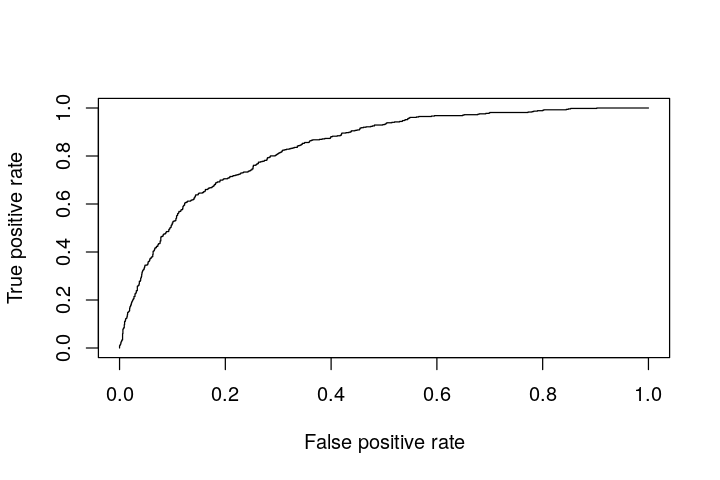

In [10]:
library(ROCR)
options(repr.plot.height=4,repr.plot.width=6)
 

df_pred<-data.frame(pred=predict(model,dfchurn.test,type="response"), 
                    real= dfchurn.test$Churn)
df_pred<-na.omit(df_pred)

pr <- prediction(df_pred$pred, df_pred$real)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf)

In [11]:
prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

[1] "The AUC is 0.836055139647363"

Repasemos la matriz de confusión:


|.|Predecimos condición negativa|Predecimos condición positiva|
|-|-|-|
|Condición negativa| $M_{11}$ | $M_{12}$|
|Condición positiva| $M_{21}$ | $M_{22}$ |

**Precisión** : $\frac{M_{22}}{M_{12}+M_{22}}$. Cuantos aciertos tengo del total de predicciones. Nos habla de **calidad**.

**Exhaustividad** o **sensibilidad** (recall, true positive rate): $\frac{M_{22}}{M_{21}+M_{22}}$. Que ratio de los aciertos positivos soy capaz de encontrar. Nos habla de **cantidad** de encuentros.

**Exactitud** (Accuracy): $\frac{M_{11}+M_{22}}{M_{11}+M_{12}+M_{21}+M_{22}}$: Cuantas predicciones correctas he hecho.

**Valor-F**: $F_\beta=(1+\beta^2)\frac{Precisión·Exhaustividad}{\beta^2·Precisión+Exhaustividad}$



In [12]:
library(caret)
library(e1071)


cf_m<-confusionMatrix(data=factor(predict(model,dfchurn.test,type="response")>0.5,
                                  labels=c("No","Yes")), 
                      reference=dfchurn.test$Churn,
                      positive="Yes")
cf_m
# Más información de como obtener esas figuras:
# https://www.rdocumentation.org/packages/caret/versions/6.0-85/topics/confusionMatrix

Loading required package: lattice

Loading required package: ggplot2

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1392  227
       Yes  185  309
                                          
               Accuracy : 0.805           
                 95% CI : (0.7875, 0.8217)
    No Information Rate : 0.7463          
    P-Value [Acc > NIR] : 1.086e-10       
                                          
                  Kappa : 0.4714          
                                          
 Mcnemar's Test P-Value : 0.04339         
                                          
            Sensitivity : 0.5765          
            Specificity : 0.8827          
         Pos Pred Value : 0.6255          
         Neg Pred Value : 0.8598          
             Prevalence : 0.2537          
         Detection Rate : 0.1462          
   Detection Prevalence : 0.2338          
      Balanced Accuracy : 0.7296          
                                          
       'Positive' Class : Yes             
                        

In [14]:
paste("La precisión es:",cf_m$table[2,2]/sum(cf_m$table[2,]))
paste("La exhaustividad (recall, sensitivity) es:",cf_m$table[2,2]/sum(cf_m$table[,2]))
paste("La exactitud (accuracy) es:",(cf_m$table[2,2]+cf_m$table[1,1])/sum(cf_m$table))

bnt_test=binom.test(cf_m$table[2,2]+cf_m$table[1,1],sum(cf_m$table))
paste("El intervalo de confianza de la exactitud es: [",paste0(bnt_test$conf.int,collapse=","),"]")


[1] "La precisión es: 0.625506072874494"

[1] "La exhaustividad (recall, sensitivity) es: 0.576492537313433"

[1] "La exactitud (accuracy) es: 0.805016564126834"

[1] "El intervalo de confianza de la exactitud es: [ 0.787468922463158,0.821713774711386 ]"

In [15]:
library(MASS)
#model<-glm(data=dfchurn.train,formula=Churn~.,family=binomial())

# Nos encuentra el modelo con menor AIC
model_optim_aic<-stepAIC(model, direction="both", trace=0)

In [16]:
summary(model_optim_aic)


Call:
glm(formula = Churn ~ SeniorCitizen + Dependents + tenure + MultipleLines + 
    InternetService + Contract + PaperlessBilling + PaymentMethod + 
    TotalCharges, family = binomial(), data = dfchurn.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8307  -0.6896  -0.2845   0.7493   3.5202  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -6.587e-01  1.467e-01  -4.490 7.12e-06 ***
SeniorCitizenYes                      2.621e-01  9.918e-02   2.642 0.008234 ** 
DependentsYes                        -2.340e-01  9.685e-02  -2.416 0.015671 *  
tenure                               -6.200e-02  7.136e-03  -8.689  < 2e-16 ***
MultipleLinesNo phone service         6.561e-01  1.575e-01   4.167 3.08e-05 ***
MultipleLinesYes                      2.104e-01  9.507e-02   2.213 0.026864 *  
InternetServiceFiber optic            9.270e-01  1.131e-01   8.197 2.47e-16 ***
InternetServiceNo

El caso de PaymentMethod es bastante curioso: Hay valores para los cuales la diferencia no es estadísitcamente significativa, pero hay otros que sí.

El único valor estadísticamente significativo parece que es "Electronic check"

Dentro de esta variable categórica vamos a comprobar que valores podemos separar y cuales agrupar.

In [17]:
levels(dfchurn$PaymentMethod)

[1] "Bank transfer (automatic)" "Credit card (automatic)"  
[3] "Electronic check"          "Mailed check"

In [18]:
tbl_payment<-table( dfchurn[c("Churn","PaymentMethod")])
tbl_payment

     PaymentMethod
Churn Bank transfer (automatic) Credit card (automatic) Electronic check
  No                       1286                    1290             1294
  Yes                       258                     232             1071
     PaymentMethod
Churn Mailed check
  No          1304
  Yes          308

Hacemos un test chi-cuadrado para corroborar que la probabilidad de churn depende del método de pago.

In [19]:
chisq.test(tbl_payment)


	Pearson's Chi-squared test

data:  tbl_payment
X-squared = 648.14, df = 3, p-value < 2.2e-16


El test estadístico nos dice que al menos un método de pago es diferente:

In [20]:
prop.table(tbl_payment,margin=2)

     PaymentMethod
Churn Bank transfer (automatic) Credit card (automatic) Electronic check
  No                  0.8329016               0.8475690        0.5471459
  Yes                 0.1670984               0.1524310        0.4528541
     PaymentMethod
Churn Mailed check
  No     0.8089330
  Yes    0.1910670

In [21]:
df_payment<-data.frame(apply(tbl_payment,2,function(x){binom.test(x)$conf.int}))
df_payment

Bank.transfer..automatic.,Credit.card..automatic.,Electronic.check,Mailed.check
<dbl>,<dbl>,<dbl>,<dbl>
0.8133406,0.8285144,0.5268250,0.7888753
0.8511870,0.8652714,0.5673498,0.8278588


Podemos juntar todos los grupos en "Electronic check" y "Otro".

In [22]:
dfchurn$ElectronicCheck<-factor(dfchurn$PaymentMethod=="Electronic check",labels=c("No","Yes"))
dfchurn.train<-dfchurn[idx,]
dfchurn.test<-dfchurn[-idx,]

In [23]:
model2<-glm(formula = Churn ~ SeniorCitizen + Dependents + tenure + MultipleLines + 
    InternetService + Contract + PaperlessBilling + ElectronicCheck + 
    TotalCharges, family = binomial(), data = dfchurn.train)
summary(model2)


Call:
glm(formula = Churn ~ SeniorCitizen + Dependents + tenure + MultipleLines + 
    InternetService + Contract + PaperlessBilling + ElectronicCheck + 
    TotalCharges, family = binomial(), data = dfchurn.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8310  -0.6847  -0.2871   0.7492   3.5208  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -7.322e-01  1.144e-01  -6.398 1.57e-10 ***
SeniorCitizenYes               2.618e-01  9.914e-02   2.641 0.008268 ** 
DependentsYes                 -2.351e-01  9.682e-02  -2.429 0.015157 *  
tenure                        -6.202e-02  7.063e-03  -8.781  < 2e-16 ***
MultipleLinesNo phone service  6.522e-01  1.573e-01   4.146 3.39e-05 ***
MultipleLinesYes               2.112e-01  9.488e-02   2.225 0.026051 *  
InternetServiceFiber optic     9.276e-01  1.123e-01   8.264  < 2e-16 ***
InternetServiceNo             -5.996e-01  1.544e-01  -3.883 0.000103 **

In [31]:
cf_m2<-confusionMatrix(factor(predict(model2,dfchurn.test,type="response")>0.5,
                             labels=c("No","Yes")), 
                      dfchurn.test$Churn,positive="Yes")
cf_m2

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1393  226
       Yes  184  310
                                          
               Accuracy : 0.806           
                 95% CI : (0.7884, 0.8226)
    No Information Rate : 0.7463          
    P-Value [Acc > NIR] : 5.414e-11       
                                          
                  Kappa : 0.4739          
                                          
 Mcnemar's Test P-Value : 0.04288         
                                          
            Sensitivity : 0.5784          
            Specificity : 0.8833          
         Pos Pred Value : 0.6275          
         Neg Pred Value : 0.8604          
             Prevalence : 0.2537          
         Detection Rate : 0.1467          
   Detection Prevalence : 0.2338          
      Balanced Accuracy : 0.7308          
                                          
       'Positive' Class : Yes             
                        

In [32]:
paste("La precisión es:",cf_m$table[2,2]/sum(cf_m$table[2,]))
paste("La exhaustividad (recall, sensitivity) es:",cf_m$table[2,2]/sum(cf_m$table[,2]))
paste("La exactitud (accuracy) es:",(cf_m$table[2,2]+cf_m$table[1,1])/sum(cf_m$table))

[1] "La precisión es: 0.625506072874494"

[1] "La exhaustividad (recall, sensitivity) es: 0.576492537313433"

[1] "La exactitud (accuracy) es: 0.805016564126834"

In [33]:

df_pred<-data.frame(pred=predict(model2,dfchurn.test,type="response"), 
                    real= dfchurn.test$Churn)
df_pred<-na.omit(df_pred)

prf_auc=performance(pr, measure = "auc")
paste("The AUC is",prf_auc@y.values[[1]])

[1] "The AUC is 0.836055139647363"

In [34]:
cf_m$table
cf_m2$table

          Reference
Prediction   No  Yes
       No  1392  227
       Yes  185  309

          Reference
Prediction   No  Yes
       No  1393  226
       Yes  184  310

Se puede profundizar más en estos datos mirando el notebook:

https://www.kaggle.com/farazrahman/telco-customer-churn-logisticregression

### Análisis matriz confusión test SARS-Covid-2

En la siguiente imagen tenemos el prospecto de un test covid:

![](img/test_covid.jpg)


|.|Resultado PCR +|Resultado PCR -| Total |
|-|-|-|-|
|Test antígenos +| 425|1|426|
|Test antígenos -| 10| 627|637|
|Total|435|628|1063|


Repasemos la matriz de confusión:


|.|Predecimos condición negativa|Predecimos condición positiva|
|-|-|-|
|Condición negativa| $M_{11}$ | $M_{12}$|
|Condición positiva| $M_{21}$ | $M_{22}$ |

**Precisión** : $\frac{M_{22}}{M_{12}+M_{22}}$. Cuantos aciertos tengo del total de predicciones. Nos habla de **calidad**.

**Exhaustividad** (recall, true positive rate): $\frac{M_{22}}{M_{21}+M_{22}}$. Que ratio de los aciertos positivos soy capaz de encontrar. Nos habla de **cantidad** de encuentros.

**Exactitud** (Accuracy): $\frac{M_{11}+M_{22}}{M_{11}+M_{12}+M_{21}+M_{22}}$: Cuantas predicciones correctas he hecho.

**Valor-F**: $F_\beta=(1+\beta^2)\frac{Precisión·Exhaustividad}{\beta^2·Precisión+Exhaustividad}$


In [32]:
M <- matrix(c(425,1,10,627),ncol=2, byrow = TRUE)
colnames(M)<-c('pos','neg')
rownames(M)<-c('pos','neg')
caret::confusionMatrix(M)

Confusion Matrix and Statistics

    pos neg
pos 425   1
neg  10 627
                                          
               Accuracy : 0.9897          
                 95% CI : (0.9816, 0.9948)
    No Information Rate : 0.5908          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9785          
                                          
 Mcnemar's Test P-Value : 0.01586         
                                          
            Sensitivity : 0.9770          
            Specificity : 0.9984          
         Pos Pred Value : 0.9977          
         Neg Pred Value : 0.9843          
             Prevalence : 0.4092          
         Detection Rate : 0.3998          
   Detection Prevalence : 0.4008          
      Balanced Accuracy : 0.9877          
                                          
       'Positive' Class : pos             
                                          

In [16]:
# PPA (positive percent agreement)
paste("Sensibilidad (PPA):", 425/(425+10)*100)

[1] "Sensibilidad (PPA): 97.7011494252874"

In [31]:
# NPA (negative percent agreement)
paste("Especificidad (NPA):", 627/(627+1))

[1] "Especificidad (NPA): 0.998407643312102"

In [36]:
# En el test lo llaman precisión pero nosotros lo hemos llamado exactitud
# https://es.wikipedia.org/wiki/Precisi%C3%B3n_y_exactitud#En_clasificaci%C3%B3n_binaria
# OPA (Overall Percent Agreement)
paste("Exactitud (OPA):",(425+627)/1063*100)

[1] "Exactitud (OPA): 98.9651928504233"

In [42]:
binom.test(425+627,1063)


	Exact binomial test

data:  425 + 627 and 1063
number of successes = 1052, number of trials = 1063, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.9815600 0.9948233
sample estimates:
probability of success 
             0.9896519 


In [38]:
#Positive Prediction Value (PPV)
paste("Precisión test positivo:",425/(425+1)*100)

#Negative Prediction Value (PPV)
paste("Precisión test negativo:",627/(627+10)*100)

[1] "Precisión test positivo: 99.7652582159624"

[1] "Precisión test negativo: 98.4301412872841"

**Objetivo**

Si doy positivo en el test, ¿cual es la probabilidad de que realmente esté enfermo?

Por simplicidad (https://xkcd.com/2587/) vamos a suponer que el test PCR de la matriz de confusión tiene una fiabilidad del 100%.

Así pues la matriz de confusión la renombraríamos así:

|.|COVID|Sano| Total |
|-|-|-|-|
|test+| 425|1|426|
|test-| 10| 627|637|
|Total|435|628|1063|


Nos están preguntando: Pr(COVID|test+)

Utilizando Bayes:
\\[
Pr(COVID|test+)=\frac{ Pr(test+|COVID)·Pr(COVID)}{Pr(test+)}
\\]

Pero desconocemos $P(test+)$, aunque podemos obtenerlo mediante:
\\[
\begin{split}
Pr(test+)&=Pr(test+,COVID)+Pr(test+,sano) \\
Pr(test+)&=Pr(test+|COVID)·Pr(COVID)+Pr(test+|sano)·Pr(sano) \\
\end{split}
\\]

Pero sabemos que:
* Sensibilidad (PPA) = Pr(test+|COVID) = 425/(425+10) = 97.7%
* Probabilidad de falso positivo (False Positive Rate) = Pr(test+|sano) = 1/(627+1) = 0.16%
* Incidencia acumulada = Pr(COVID) = 500/100.000 = 0.5%
* Pr(sano) = 1-Pr(COVID) = 99.5%

In [96]:
p_testOK_covid = M[1,1]/sum(M[,1])
p_testOK_sano = M[1,2]/sum(M[,2])
p_covid = 500/100000
p_sano = 1-p_covid

p_testOK = p_testOK_covid*p_covid+p_testOK_sano*p_sano

In [97]:
p_covid_testOK = p_testOK_covid*p_covid/p_testOK
p_covid_testOK

[1] 0.755096

In [74]:
paste("La probabilidad de tener COVID si el test es positivo es del ",round(p_covid_testOK*100,2),"%", sep='')

[1] "La probabilidad de tener COVID si el test es positivo es del 75.51%"

Si la probabilidad de COVID en la vida real fuera la misma la que hay en el estudio, entonces tendríamos que Pr(COVID|test+) es la Precisión test positivo que calculamos antes

In [67]:
p_covid = 435/1063
p_testOK = p_testOK_covid*p_covid+p_testOK_sano*p_sano
p_covid_testOK = p_testOK_covid*p_covid/p_testOK
p_covid_testOK

[1] 0.9976526